In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

def getConserved( rho, vx, vy, gamma, vol ):
    """
    Calculate the conserved variable from the primitive
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vy       is matrix of cell y-velocity
    gamma    is ideal gas gamma
    vol      is cell volume
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    Momy     is matrix of y-momentum in cells
    """
    Mass   = rho * vol
    Momx   = rho * vx
    Momy   = rho * vy

    return Mass, Momx, Momy

def getPrimitive( Mass, Momx, Momy, gamma, vol):
  """
  Calculate the primitive variable from the conservative
  Mass     is matrix of mass in cells
  Momx     is matrix of x-momentum in cells
  Momy     is matrix of y-momentum in cells
  gamma    is ideal gas gamma
  vol      is cell volume
  rho      is matrix of cell densities
  vx       is matrix of cell x-velocity
  vy       is matrix of cell y-velocity
  P        is matrix of cell pressures
  """
  rho = Mass / vol
  vx  = Momx / rho
  vy  = Momy / rho
  P   = (rho)**gamma

  return rho, vx, vy, P

def getSpeedOfSound(rho, gamma):
  '''
  find the speed of sound in the fluid
  rho

  '''
  cs = np.sqrt((gamma)*(rho)**(gamma-1))

  return cs
'''
These are auxiliary functions in for the gradient
'''

def minmod2(x,y):
  return (np.sign(x) + np.sign(y))*np.minimum(np.abs(x), np.abs(y))/2

def minmod3(x,y,z):
  return minmod2(x,minmod2(y,z))


def getGradient(f, dx, axis=0, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size in x direction
    axis     is the axis of x-direction
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """


    df_dx = np.zeros(f.shape)
    n = f.shape[axis]
    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)

    if axis == 0:
      df_dx =  minmod3( theta * ( f - f[Km1][:, K] )/dx, (f[Kp1][:, K] - f[Km1][:, K] ) / (2*dx),theta * ( f[Kp1][:, K] - f ) / dx)
    elif axis == 1:
      df_dx = minmod3( theta * ( f - f[K][:, Km1] )/dx, (f[K][:, Kp1] - f[K][:, Km1] ) / (2*dx),theta * ( f[K][:, Kp1] - f ) / dx)

    return df_dx


def extrapolateInSpaceToFace(q, q_dx, dx, axis=0):
    """
    Calculate the gradients of a field
    q        is a matrix of the field
    q_dx     is a matrix of the field x-derivatives
    dx       is the cell size
    q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
    q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
    """

    n = q.shape[axis]

    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)


    qP_XL = np.zeros_like(q)
    qP_XR = np.zeros_like(q)
    qM_XR = np.zeros_like(q)
    qM_XL = np.zeros_like(q)

    if axis == 0:
      qP_XL = q - q_dx * dx/2
      qP_XR = q[Kp1][:, K] - q_dx[Kp1][:, K] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[Km1][:, K] + q_dx[Km1][:, K] * dx/2

    elif axis == 1:
      qP_XL = q - q_dx * dx/2
      qP_XR = q[K][:, Kp1] - q_dx[K][:, Kp1] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[K][:, Km1] + q_dx[K][:, Km1] * dx/2


    return qM_XL, qP_XL, qM_XR, qP_XR


def local_propagation_speed(rho, eta, zeta, tau_nu, cs):

   '''
    Get the local propagation speeds using the eigenvalues
    of the flux matrix of the non relativistic IS equations

    rho          is a matrix of density
    eta
    zeta
    tau_nu
    cs           is the speed of sound
    '''




   C3 = np.sqrt(eta*tau_nu/rho)

   C4 = cs*np.sqrt((zeta + 4/3 * tau_nu)/(rho*tau_nu))

   C = np.maximum(C3,C4)

   return C

def getXFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, Pixx_P, Pixx_M, Pixy_P,
              Pixy_M, Piyx_P, Piyx_M, Piyy_P, Piyy_M, gamma, eta,
              zeta, tau_nu):

    """

    Calculate fluxes between 2 states with local Kurganov Tadmor rule
    rho_P        is a matrix of left-state  density
    rho_M        is a matrix of right-state density
    vx_P         is a matrix of left-state  x-velocity
    vx_M         is a matrix of right-state x-velocity
    vy_P         is a matrix of left-state  y-velocity
    vy_M         is a matrix of right-state y-velocity
    Pi_P         is a matrix of left-state bulk viscosity
    Pi_M         is a matrix of right-state bulk viscosity
    P_P          is a matrix of left-state  pressure
    P_M          is a matrix of right-state pressure
    gamma        is the ideal gas gamma
    flux_Mass    is the matrix of mass fluxes
    flux_Momx    is the matrix of x-momentum fluxes
    flux_Momy    is the matrix of x-momentum fluxes
    flux_Pi_v    is the matrix of the bulk viscosity var

    """

    # compute (averaged) states over the left and right states

    # x fluxes

    rho_av   = 0.5*(rho_P + rho_M)
    momx_av  = 0.5*(rho_P * vx_P + rho_M * vx_M)
    Pixx_av  = 0.5*(Pixx_P + Pixx_M)
    Piyx_av  = 0.5*(Piyx_P + Piyx_M)
    Pixx_vx_av = 0.5*(Pixx_P * vx_P + Pixx_M * vx_M)
    Pixy_vx_av = 0.5*(Pixy_P * vx_P + Pixy_M * vx_M)
    Piyx_vx_av = 0.5*(Piyx_P * vx_P + Piyx_M * vx_M)
    Piyy_vx_av = 0.5*(Piyy_P * vx_P + Piyy_M * vx_M)

    # compute fluxes

    B = eta/tau_nu
    A = zeta/tau_nu


    flux_Mass   = momx_av
    flux_Momx   = 0.5*(rho_P*(vx_P)**2 + rho_M*(vx_M)**2) + ((rho_P**gamma + rho_M**gamma)*0.5 + Pixx_av)/gamma
    flux_Momy   = 0.5*(rho_P*(vx_P*vy_P) + rho_M*(vx_M*vy_M)) + (Piyx_av)/gamma
    flux_Pixx_vx   = Pixx_vx_av + B * (vx_P + vx_M) + (A - 2/3 * B) * (vx_P + vx_M) * 0.5
    flux_Pixy_vx   = Pixy_vx_av + B * (vy_P + vy_M) * 0.5
    flux_Piyx_vx   = Piyx_vx_av + B * (vy_P + vy_M) * 0.5
    flux_Piyy_vx   = Piyy_vx_av + (A - 2/3 * B) * (vx_P + vx_M) * 0.5

    # find wavespeeds

    cs_P = getSpeedOfSound(rho_P,gamma)

    C_P = local_propagation_speed(rho_P , eta, zeta, tau_nu, cs_P) # max propagation speed from the left

    cs_M = getSpeedOfSound(rho_M,gamma)

    C_M = local_propagation_speed(rho_M , eta, zeta, tau_nu, cs_M) # max propagation speed from the right

    C = np.maximum(C_M, C_P)

    # add stabilizing diffusive term
    flux_Mass    -= C * 0.5 * (rho_P - rho_M)
    flux_Momx    -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
    flux_Momy    -= C * 0.5 * (rho_P * vy_P - rho_M * vy_M)
    flux_Pixx_vx -= C * 0.5 * ( Pixx_P - Pixx_M )
    flux_Pixy_vx -= C * 0.5 * ( Pixy_P - Pixy_M )
    flux_Piyx_vx -= C * 0.5 * ( Piyx_P - Piyx_M )
    flux_Piyy_vx -= C * 0.5 * ( Piyy_P - Piyy_M )

    return flux_Mass, flux_Momx, flux_Momy, flux_Pixx_vx, flux_Pixy_vx, flux_Piyx_vx, flux_Piyy_vx

def getYFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, Pixx_P, Pixx_M, Pixy_P,
              Pixy_M, Piyx_P, Piyx_M, Piyy_P, Piyy_M, gamma, eta,
              zeta, tau_nu):


  """

  Calculate fluxes between 2 states with local Kurganov Tadmor rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  vy_P         is a matrix of left-state  y-velocity
  vy_M         is a matrix of right-state y-velocity
  Pi_P         is a matrix of left-state bulk viscosity
  Pi_M         is a matrix of right-state bulk viscosity
  gamma        is the ideal gas gamma
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_Momy    is the matrix of x-momentum fluxes
  flux_Pi_v    is the matrix of the bulk viscosity var

  """

  # compute (averaged) states over the left and right states

  # y fluxes

  rho_av   = 0.5*(rho_P + rho_M)
  momy_av  = 0.5*(rho_P * vy_P + rho_M * vy_M)
  Piyy_av  = 0.5*(Piyy_P + Piyy_M)
  Pixy_av  = 0.5*(Pixy_P + Pixy_M)
  Pixx_vy_av = 0.5*(Pixx_P * vy_P + Pixx_M * vy_M)
  Pixy_vy_av = 0.5*(Pixy_P * vy_P + Pixy_M * vy_M)
  Piyx_vy_av = 0.5*(Piyx_P * vy_P + Piyx_M * vy_M)
  Piyy_vy_av = 0.5*(Piyy_P * vy_P + Piyy_M * vy_M)

  # compute fluxes

  B = eta/tau_nu
  A = zeta/tau_nu


  flux_Mass   = momy_av
  flux_Momx   = 0.5*(rho_P*(vx_P*vy_P) + rho_M*(vx_M*vy_M)) + (Pixy_av)/gamma
  flux_Momy   = 0.5*(rho_P*(vy_P)**2 + rho_M*(vy_M)**2) + ((rho_P**gamma + rho_M**gamma)*0.5 + Piyy_av)/gamma
  flux_Pixx_vy   = Pixx_vy_av + (A - 2/3 * B) * (vy_P + vy_M) * 0.5
  flux_Pixy_vy   = Pixy_vy_av + B * (vx_P + vx_M) * 0.5
  flux_Piyx_vy   = Piyx_vy_av + B * (vx_P + vx_M) * 0.5
  flux_Piyy_vy   = Piyy_vy_av + B * (vy_P + vy_M) + (A - 2/3 * B) * (vy_P + vy_M) * 0.5


  # find wavespeeds

  cs_P = getSpeedOfSound(rho_P,gamma)

  C_P = local_propagation_speed(rho_P , eta, zeta, tau_nu, cs_P) # max propagation speed from the left

  cs_M = getSpeedOfSound(rho_M,gamma)

  C_M = local_propagation_speed(rho_M , eta, zeta, tau_nu, cs_M) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass    -= C * 0.5 * (rho_P - rho_M)
  flux_Momx    -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
  flux_Momy    -= C * 0.5 * (rho_P * vy_P - rho_M * vy_M)
  flux_Pixx_vy -= C * 0.5 * ( Pixx_P - Pixx_M )
  flux_Pixy_vy -= C * 0.5 * ( Pixy_P - Pixy_M )
  flux_Piyx_vy -= C * 0.5 * ( Piyx_P - Piyx_M )
  flux_Piyy_vy -= C * 0.5 * ( Piyy_P - Piyy_M )

  return flux_Mass, flux_Momx, flux_Momy, flux_Pixx_vy, flux_Pixy_vy, flux_Piyx_vy, flux_Piyy_vy


def applyFluxes(flux_H1_X, flux_H2_X, flux_H1_Y, flux_H2_Y, dx, dy, J = 0):
    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    flux_H1_Y is a matrix of the y-dir fluxes from the right
    flux_H2_Y is a matrix of the y-dir fluxes from the left
    dx        is the cell size in the x direction
    dy        is the cell size in the y direction
    """
    C = 0

    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C -= (flux_H1_Y - flux_H2_Y ) / dy
    C += J

    return C




Time integrators

In [4]:
def Heuns(q,f,dt,t):

  k1 = dt*f(t,q)
  k2 = dt*f(t + dt,q + k1)

  return q + 0.5 * (k1 + k2)

def RK4(y0,f,h,t):

  k1 = h * (f(t, y0))
  k2 = h * (f((t+h/2), (y0+k1/2)))
  k3 = h * (f((t+h/2), (y0+k2/2)))
  k4 = h * (f((t+h), (y0+k3)))
  k = (k1+2*k2+2*k3+k4)/6
  yn = y0 + k

  return yn



In [5]:
def KTschemeNonRelativisticIS(t,IC, dx, dy, N, gamma, zeta, tau_nu, eta, theta=1):

    """ Finite Volume simulation """

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''
    rho = IC[0:N]


    ''' Initial conditions for v'''

    Momx = IC[N:2*N]
    Momy = IC[2*N:3*N]
    vx = IC[N:2*N] / rho
    vy = IC[2*N:3*N] / rho


    ''' Pressure due to equation of state '''
    P = rho**gamma


    ''' Pi initial condition '''
    Pixx = IC[3*N:4*N]
    Pixy = IC[4*N:5*N]
    Piyx = IC[5*N:6*N]
    Piyy = IC[6*N:]


    # get Speed of sound
    cs = getSpeedOfSound(rho, gamma)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # calculate gradients
    # getGradient(f, dx, axis=0, theta=1)

    rho_dx = getGradient(rho,  dx, 0, theta)
    vx_dx  = getGradient(vx,   dx, 0, theta)
    vy_dx  = getGradient(vy,   dx, 0, theta)
    P_dx   = getGradient(P,    dx, 0, theta)
    Pixx_dx  = getGradient(Pixx,   dx, 0, theta)
    Pixy_dx  = getGradient(Pixy,   dx, 0, theta)
    Piyx_dx  = getGradient(Piyx,   dx, 0, theta)
    Piyy_dx  = getGradient(Piyy,   dx, 0, theta)

    rho_dy = getGradient(rho,  dy, 1, theta)
    vx_dy  = getGradient(vx,   dy, 1, theta)
    vy_dy  = getGradient(vy,   dy, 1, theta)
    P_dy   = getGradient(P,    dy, 1, theta)
    Pixx_dy  = getGradient(Pixx,   dy, 1, theta)
    Pixy_dy  = getGradient(Pixy,   dx, 1, theta)
    Piyx_dy  = getGradient(Piyx,   dx, 1, theta)
    Piyy_dy  = getGradient(Piyy,   dx, 1, theta)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # extrapolate in space to face centers
    # input extrapolateInSpaceToFace(q, q_dx, dx, axis=0)
    # output qM_XL, qP_XL, qM_XR, qP_XR

    rhoM_XL, rhoP_XL, rhoM_XR, rhoP_XR = extrapolateInSpaceToFace(rho, rho_dx, dx, 0)
    vxM_XL,  vxP_XL,  vxM_XR,  vxP_XR  = extrapolateInSpaceToFace(vx,  vx_dx,   dx, 0)
    vyM_XL,  vyP_XL,  vyM_XR,  vyP_XR  = extrapolateInSpaceToFace(vy,  vy_dx,   dx, 0)
    PixxM_XL,  PixxP_XL,  PixxM_XR,  PixxP_XR  = extrapolateInSpaceToFace(Pixx,  Pixx_dx,  dx, 0)
    PixyM_XL,  PixyP_XL,  PixyM_XR,  PixyP_XR  = extrapolateInSpaceToFace(Pixy,  Pixy_dx,  dx, 0)
    PiyxM_XL,  PiyxP_XL,  PiyxM_XR,  PiyxP_XR  = extrapolateInSpaceToFace(Piyx,  Piyx_dx,  dx, 0)
    PiyyM_XL,  PiyyP_XL,  PiyyM_XR,  PiyyP_XR  = extrapolateInSpaceToFace(Piyy,  Piyy_dx,  dx, 0)

    rhoM_YL, rhoP_YL, rhoM_YR, rhoP_YR = extrapolateInSpaceToFace(rho, rho_dy, dy, 1)
    vxM_YL,  vxP_YL,  vxM_YR,  vxP_YR  = extrapolateInSpaceToFace(vx,  vx_dy,  dy, 1)
    vyM_YL,  vyP_YL,  vyM_YR,  vyP_YR  = extrapolateInSpaceToFace(vy,  vy_dy,  dy, 1)
    PixxM_YL,  PixxP_YL,  PixxM_YR,  PixxP_YR  = extrapolateInSpaceToFace(Pixx,  Pixx_dy,  dy, 1)
    PixyM_YL,  PixyP_YL,  PixyM_YR,  PixyP_YR  = extrapolateInSpaceToFace(Pixy,  Pixy_dy,  dy, 1)
    PiyxM_YL,  PiyxP_YL,  PiyxM_YR,  PiyxP_YR  = extrapolateInSpaceToFace(Piyx,  Piyx_dy,  dy, 1)
    PiyyM_YL,  PiyyP_YL,  PiyyM_YR,  PiyyP_YR  = extrapolateInSpaceToFace(Piyy,  Piyy_dy,  dy, 1)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # compute fluxes (local Kurganov-Tadmor)
    # getXFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, Pixx_P, Pixx_M, Pixy_P,
    #          Pixy_M, Piyx_P,Piyx_M, Piyy_P, Piyy_M, P_P, P_M, gamma, eta,
    #          zeta, tau_nu):
    # getYFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, Pixx_P, Pixx_M, Pixy_P,
    #          Pixy_M, Piyx_P,Piyx_M, Piyy_P, Piyy_M, P_P, P_M, gamma, eta,
    #          zeta, tau_nu):
    # output flux_Mass, flux_Momx, flux_Momy, flux_Pixx_vx, flux_Pixy_vx, flux_Piyx_vx, flux_Piyy_vx
    # output flux_Mass, flux_Momx, flux_Momy, flux_Pixx_vy, flux_Pixy_vy, flux_Piyx_vy, flux_Piyy_vy



    flux_Mass_XR, flux_Momx_XR, flux_Momy_XR, flux_Pixx_vxR, flux_Pixy_vxR, flux_Piyx_vxR, flux_Piyy_vxR = getXFlux(rhoP_XR, rhoM_XR, vxP_XR, vxM_XR,
                                            vyP_XR, vyM_XR, PixxP_XR, PixxM_XR,
                                            PixyP_XR, PixyM_XR, PiyxP_XR, PiyxM_XR,
                                            PiyyP_XR, PiyyM_XR, gamma, eta, zeta, tau_nu)

    flux_Mass_XL, flux_Momx_XL, flux_Momy_XL, flux_Pixx_vxL, flux_Pixy_vxL, flux_Piyx_vxL, flux_Piyy_vxL = getXFlux(rhoP_XL, rhoM_XL, vxP_XL, vxM_XL,
                                            vyP_XL, vyM_XL, PixxP_XL, PixxM_XL,
                                            PixyP_XL, PixyM_XL, PiyxP_XL, PiyxM_XL,
                                            PiyyP_XL, PiyyM_XL, gamma, eta, zeta, tau_nu)

    flux_Mass_YR, flux_Momx_YR, flux_Momy_YR, flux_Pixx_vyR, flux_Pixy_vyR, flux_Piyx_vyR, flux_Piyy_vyR = getYFlux(rhoP_YR, rhoM_YR, vxP_YR, vxM_YR,
                                            vyP_YR, vyM_YR, PixxP_YR, PixxM_YR,
                                            PixyP_YR, PixyM_YR, PiyxP_YR, PiyxM_YR,
                                            PiyyP_YR, PiyyM_YR, gamma, eta, zeta, tau_nu)

    flux_Mass_YL, flux_Momx_YL, flux_Momy_YL, flux_Pixx_vyL, flux_Pixy_vyL, flux_Piyx_vyL, flux_Piyy_vyL = getYFlux(rhoP_YL, rhoM_YL, vxP_YL, vxM_YL,
                                            vyP_YL, vyM_YL, PixxP_YL, PixxM_YL,
                                            PixyP_YL, PixyM_YL, PiyxP_YL, PiyxM_YL,
                                            PiyyP_YL, PiyyM_YL, gamma, eta, zeta, tau_nu)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # update solution

    Jxx = - Pixx/tau_nu
    Jxy = - Pixy/tau_nu
    Jyx = - Piyx/tau_nu
    Jyy = - Piyy/tau_nu


    timederivative_rho = applyFluxes( flux_Mass_XR,   flux_Mass_XL, flux_Mass_YR,   flux_Mass_YL,  dx, dy)
    timederivative_Momx = applyFluxes( flux_Momx_XR,   flux_Momx_XL, flux_Momx_YR,   flux_Momx_YL, dx, dy)
    timederivative_Momy = applyFluxes( flux_Momy_XR,   flux_Momy_XL, flux_Momy_YR,   flux_Momy_YL, dx, dy)
    timederivative_Pixx  = applyFluxes( flux_Pixx_vxR,    flux_Pixx_vxL, flux_Pixx_vyR,    flux_Pixx_vyL, dx, dy, Jxx)
    timederivative_Pixy  = applyFluxes( flux_Pixy_vxR,    flux_Pixy_vxL, flux_Pixy_vyR,    flux_Pixy_vyL, dx, dy, Jxy)
    timederivative_Piyx  = applyFluxes( flux_Piyx_vxR,    flux_Piyx_vxL, flux_Piyx_vyR,    flux_Piyx_vyL, dx, dy, Jyx)
    timederivative_Piyy  = applyFluxes( flux_Piyy_vxR,    flux_Piyy_vxL, flux_Piyy_vyR,    flux_Piyy_vyL, dx, dy, Jyy)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    return np.vstack((timederivative_rho,timederivative_Momx,timederivative_Momy,timederivative_Pixx,timederivative_Pixy,timederivative_Piyx,timederivative_Piyy))





def applyBC(y):

  rho = y[0:N]
  vx = y[N:2*N]/rho
  vy = y[2*N:3*N]/rho

  Pixx = IC[3*N:4*N]
  Pixy = IC[4*N:5*N]
  Piyx = IC[5*N:6*N]
  Piyy = IC[6*N:]


  #Absorbing boundary conditions


  rho[0]    = rho[1]
  rho[-1]   = rho[-2]
  rho[:,0]  = rho[:,1]
  rho[:,-1] = rho[:,-2]

  vx[0]     = -vx[1]
  vx[1]     = -vx[-2]
  vx[:,0]   = 0
  vx[:,1]   = 0

  vy[0]     = 0
  vy[1]     = 0
  vy[:,0]   = -vy[:,1]
  vy[:,1]   = -vy[:,-2]

  return np.vstack((rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy))





In [6]:
def integrator(scheme, time, q0, dtmax, method = "Heuns", args=None):

  '''
  This is an integrator that evolves a

  scheme     is the method to get dy/dt e.g. KTscheme that returns return
    np.vstack((timederivative_rho,timederivative_Momx,timederivative_Momy,
    timederivative_Pixx,timederivative_Pixy,timederivative_Piyx,timederivative_Piyy))
  time       is the current time
  q0         is the current state (np.vstack((rho,Momx,Momy,Pixx,Pixy,Piyx,Piyy))
  dtmax      is the upperbound of dt set by the user
  BC         is a function that enforces the boundary conditions
  method     is the method used in the integrator
  args       are additional arguments for scheme

  Later implement more Equations of State (Eos)
  '''

  if args is not None:
        # Wrap the user's scheme in lambdas to hide the
        # additional parameters.  Pass in the original fun as a keyword
        # argument to keep it in the scope of the lambda.
        try:
            _ = [*(args)]
        except TypeError as exp:
            suggestion_tuple = (
                "Supplied 'args' cannot be unpacked. Please supply `args`"
                f" as a tuple (e.g. `args=({args},)`)")
            raise TypeError(suggestion_tuple) from exp

        scheme = lambda t, x, scheme = scheme: scheme(t, x, *args)

  # write the parameters passed to the function
  t, tEnd = time
  outputCount = 0

  Q = [q0]
  q = q0
  dx = args[0]
  N = int(args[2])
  gamma   = args[3]
  zeta    = args[4]
  tau_nu  = args[5]
  eta     = args[6]
  M = []

  while t < tEnd:

    #print(t)
    C = scheme

    # compute density to get necessary stability conditions met
    rho = q[0:N]

    #get speed of sound
    cs = getSpeedOfSound(rho,gamma)

    # condition to ensure that the time steps are small enough so that
    # waves do not interfere with each other
    # rho, eta, zeta, tau_nu, cs
    courant_number = dx/np.max(local_propagation_speed(rho, eta, zeta, tau_nu, cs))

    if (np.finfo(float).eps > courant_number):
      print("slow update")

    dt  =  np.minimum(dtmax, 0.1*courant_number)
    #print("dt: ", dt)

    # choose the scheme to integrate(evolve over time) the system
    if method == "Heuns":
      q = Heuns(q,C,dt,t)
    if method == "RK4":
      q = RK4(q,C,dt,t)



    #Apply Boundary conditions

    #q = BC(q)

    t = t+dt

    if t >= dtmax*outputCount:
      print("{:.2f}/{:.2f}".format(t,tEnd))
      Q.append(q)
      M.append(np.sum(rho*args[0]*args[0]))
      outputCount += 1

  return Q,M

In [8]:


#define simulation parameters and intial conditions

t                      = 0   # s
tEnd                   = 1  # time at the end
tOut                   = 0.01 # time of each output

N                      = 200 # resolution
boxsize                = 10.  # in some unit system l
gamma                  = 2 # adiabatic index
zeta                   = 1 # bulk viscosity coefficient
eta                    = 1
tau_nu                 = 1
theta                  = 1


# Define Mesh
dx = boxsize / N   # box size
dy = dx
vol = dx**2        # volume of each box
#xlin = np.linspace(0.5*dx, (boxsize-0.5*dx), N)# simulation limits
xlin = np.linspace(-0.5*(boxsize-0.5*dx),0.5*(boxsize-0.5*dx), N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

''' initial condition of density'''

#rho = (1.2*(R <= 0.25) + 1*(R > 0.25))
#rho = ((1 - ((R - (boxsize-0.5*dx)*0.5)**2)/0.25 )**4 )*(R < 0.5) + 0.1*np.ones(R.shape) # Mauricio`s funtion advice
rho = ((1 - R**2 )**4)*(R < 1) + 0.1*np.ones(R.shape) # Mauricio`s funtion advice
#rho = 1*(X < 0) + 0.125*(X >= 0)

''' initial condition of velocity '''
vx = np.zeros(s)
#vx = 0.5*np.ones(xlin.shape)
#vx = 3*(Y < 0) - 0*(Y >= 0)
#vx = np.abs((xlin - (boxsize-0.5*dx)*0.5)/16)

vy = np.zeros(s)
#vy = 0.5*np.ones(xlin.shape)


''' initial condition of Pi tensor '''
Pixx = np.zeros(s)
Pixy = np.zeros(s)
Piyx = np.zeros(s)
Piyy = np.zeros(s)

IC = np.vstack((rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example


# input (dx, dy, xlin, gamma, zeta, tau_nu, BC, theta=1)
# output solution list of arrays that are 7N x N in the order (rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy)
solution,mass = integrator(KTschemeNonRelativisticIS, (t, tEnd), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, zeta, tau_nu, eta, theta))
print("Done")

0.00/1.00
0.01/1.00
0.02/1.00
0.03/1.00
0.04/1.00
0.05/1.00
0.06/1.00
0.07/1.00
0.08/1.00
0.09/1.00
0.10/1.00
0.11/1.00
0.12/1.00
0.13/1.00
0.14/1.00
0.15/1.00
0.16/1.00
0.17/1.00
0.18/1.00
0.19/1.00
0.20/1.00
0.21/1.00
0.22/1.00
0.23/1.00
0.24/1.00
0.25/1.00
0.26/1.00
0.27/1.00
0.28/1.00
0.29/1.00
0.30/1.00
0.31/1.00
0.32/1.00
0.33/1.00
0.34/1.00
0.35/1.00
0.36/1.00
0.37/1.00
0.38/1.00
0.39/1.00
0.40/1.00
0.41/1.00
0.42/1.00
0.43/1.00
0.44/1.00
0.45/1.00
0.46/1.00
0.47/1.00
0.48/1.00
0.49/1.00
0.50/1.00
0.51/1.00
0.52/1.00
0.53/1.00
0.54/1.00
0.55/1.00
0.56/1.00
0.57/1.00
0.58/1.00
0.59/1.00
0.60/1.00
0.61/1.00
0.62/1.00
0.63/1.00
0.64/1.00
0.65/1.00
0.66/1.00
0.67/1.00
0.68/1.00
0.69/1.00
0.70/1.00
0.71/1.00
0.72/1.00
0.73/1.00
0.74/1.00
0.75/1.00
0.76/1.00
0.77/1.00
0.78/1.00
0.79/1.00
0.80/1.00
0.81/1.00
0.82/1.00
0.83/1.00
0.84/1.00
0.85/1.00
0.86/1.00
0.87/1.00
0.88/1.00
0.89/1.00
0.90/1.00
0.91/1.00
0.92/1.00
0.93/1.00
0.94/1.00
0.95/1.00
0.96/1.00
0.97/1.00
0.98/1.00
0.99/1.00


# Plot the simulation in 2d

In [9]:
import plotly.express as px


len(solution) # number of time steps
i=0 # if i = 0 it shows the initial contions for each i the time step increases to t+tOut defined in the previous cell


density   = px.imshow(solution[i][0:N].T, color_continuous_scale='plasma', origin='lower',title='Density')
density.show()
xvelocity = px.imshow(solution[i][N:2*N].T, title='x Velocity')
xvelocity.show()
yvelocity = px.imshow(solution[i][2*N:3*N].T, title='y Velocity')
yvelocity.show()
Pixxdata = px.imshow(solution[i][3*N:4*N].T, title='Pixx')
Pixxdata.show()
Pixydata = px.imshow(solution[i][4*N:5*N].T, title='Pixy')
Pixydata.show()
Piyxdata = px.imshow(solution[i][5*N:6*N].T, title='Piyx')
Piyxdata.show()
Piyydata = px.imshow(solution[i][6*N:].T, title='Piyy')
Piyydata.show()

Plot the solutions in time

In [ ]:
import plotly.express as px

i=0
while i < len(solution):
  density   = px.imshow(solution[i][0:N].T, color_continuous_scale='plasma', origin='lower')
  density.show()
  #xvelocity = px.imshow(solution[i][N:2*N].T)
  #xvelocity.show()
  #yvelocity = px.imshow(solution[i][2*N:3*N].T)
  #yvelocity.show()
  i+=1

Output hidden; open in https://colab.research.google.com to view.

3d projection

102


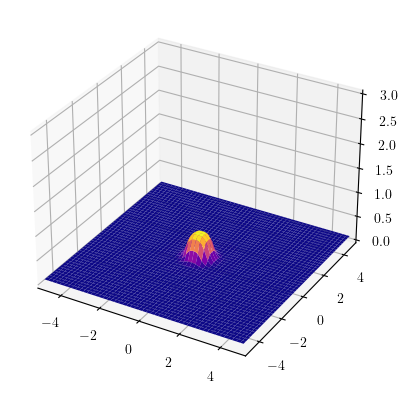

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Customize the z axis.
ax.set_zlim(0, 3.01)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

print(len(solution))
surf = ax.plot_surface(X,Y,solution[50][0:N], cmap="plasma")
ax.view_init()


# Plot 1d static slices

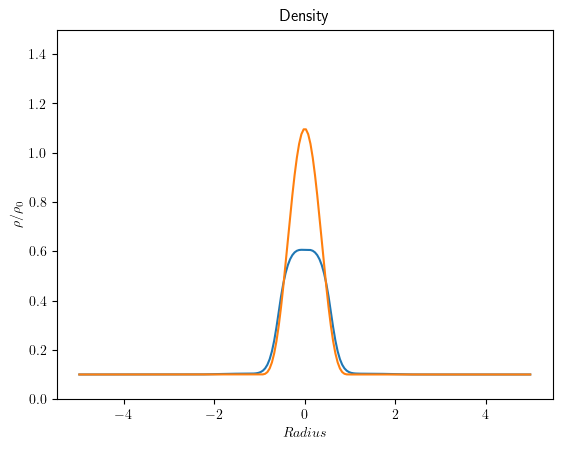

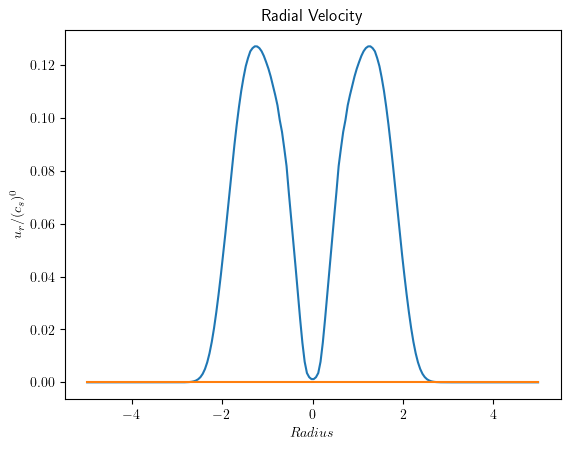

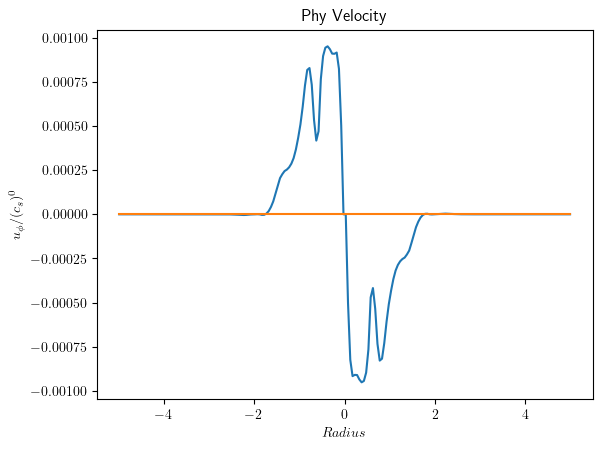

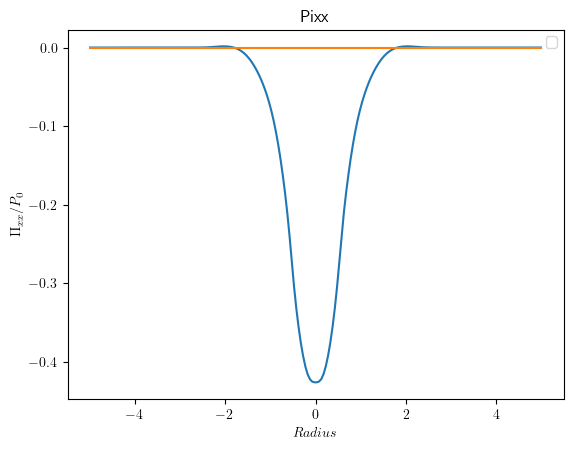

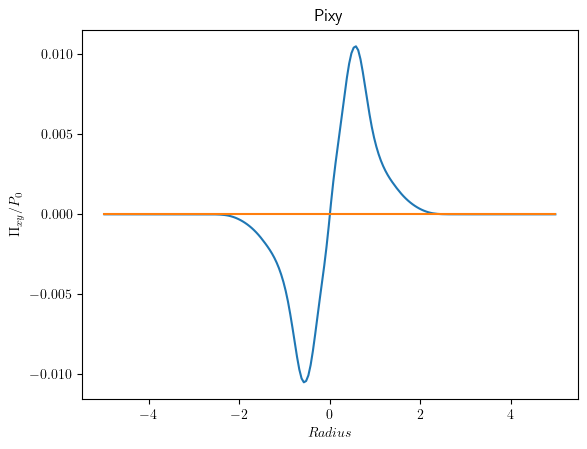

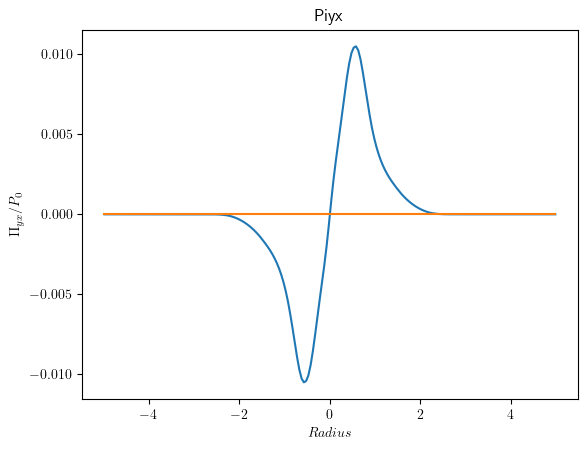

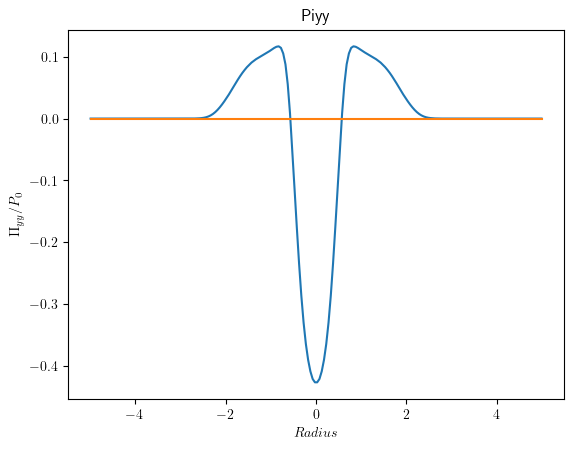

In [19]:

i=50

# slice through the center horizontally

#initial conditions
rhoic = (solution[0][:N])[int(N/2)]
uxic = solution[0][N:2*N][int(N/2)] / rhoic
uyic = solution[0][2*N:3*N][int(N/2)] / rhoic
Pixxic = solution[0][3*N:4*N][int(N/2)]
Pixyic = solution[0][4*N:5*N][int(N/2)]
Piyxic = solution[0][5*N:6*N][int(N/2)]
Piyyic = solution[0][6*N:][int(N/2)]

grad_uxic = getGradient(solution[0][N:2*N]/ (solution[0][:N]),dx,0,theta)[int(N/2)]


uric = np.sqrt(uxic**2 + uyic**2)
uphyic = (X[:][int(N/2)]*uyic - Y[:][int(N/2)]*uxic)/(R[:][int(N/2)])

#at time i*tOut
rho = (solution[i][:N])[int(N/2)]
ux = solution[i][N:2*N][int(N/2)] / rho
uy = solution[i][2*N:3*N][int(N/2)] / rho
Pixx = solution[i][3*N:4*N][int(N/2)]
Pixy = solution[i][4*N:5*N][int(N/2)]
Piyx = solution[i][5*N:6*N][int(N/2)]
Piyy = solution[i][6*N:][int(N/2)]

grad_ux = getGradient(solution[i][N:2*N]/ (solution[i][:N]),dx,0,theta)[int(N/2)]


ur = np.sqrt(ux**2 + uy**2)
uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])

# slice through the center vertically
rhoprime = (solution[i][:N].T)[int(N/2)]
uxprime = (solution[i][N:2*N].T)[int(N/2)] / rho
uyprime = (solution[i][2*N:3*N].T)[int(N/2)] / rho
Pixxprime = (solution[i][3*N:4*N].T)[int(N/2)]
Pixyprime = solution[i][4*N:5*N][int(N/2)]
Piyxprime = solution[i][5*N:6*N][int(N/2)]
Piyyprime = solution[i][6*N:][int(N/2)]



plt.ylim(0,1.5)
plt.plot(xlin,rho)
plt.plot(xlin,rhoic)
plt.title('Density')
plt.xlabel("$Radius$")
plt.ylabel(r"$\rho/\rho_0$")
plt.show()


plt.plot(xlin,ur)
plt.plot(xlin,uric)
plt.title('Radial Velocity')
plt.xlabel("$Radius$")
plt.ylabel(r"$u_r/(c_s)^{0}$")
plt.show()


plt.plot(xlin,uphy)
plt.plot(xlin,uphyic)
plt.title('Phy Velocity')
plt.xlabel("$Radius$")
plt.ylabel(r"$u_{\phi}/(c_s)^{0}$")
plt.show()

#plt.plot(xlin,grad_uxic)
#plt.plot(xlin,grad_ux)
plt.plot(xlin,Pixx)
plt.plot(xlin,Pixxic)
plt.title('Pixx')
plt.xlabel("$Radius$")
plt.ylabel(r"$\Pi_{xx}/P_0$")
plt.show()

plt.plot(xlin, Pixy)
plt.plot(xlin, Pixyic)
plt.title('Pixy')
plt.xlabel("$Radius$")
plt.ylabel(r"$\Pi_{xy}/P_0$")
plt.show()

plt.plot(xlin, Piyx)
plt.plot(xlin, Piyxic)
plt.title('Piyx')
plt.xlabel("$Radius$")
plt.ylabel(r"$\Pi_{yx}/P_0$")
plt.show()

plt.plot(xlin, Piyy)
plt.plot(xlin, Piyyic)
plt.title('Piyy')
plt.xlabel("$Radius$")
plt.ylabel(r"$\Pi_{yy}/P_0$")
plt.show()

In [ ]:
i=50

# slice through the center horizontally
rho = (solution[i][:N])[int(N/2)]
ux = solution[i][N:2*N][int(N/2)] / rho
uy = solution[i][2*N:3*N][int(N/2)] / rho
Pixx = solution[i][3*N:4*N][int(N/2)]
Pixy = solution[i][4*N:5*N][int(N/2)]
Piyx = solution[i][5*N:6*N][int(N/2)]
Piyy = solution[i][6*N:][int(N/2)]

ur = np.sqrt(ux**2 + uy**2)
uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])

# slice through the center vertically
rhoprime = (solution[i][:N].T)[int(N/2)]
uxprime = (solution[i][N:2*N].T)[int(N/2)] / rho
uyprime = (solution[i][2*N:3*N].T)[int(N/2)] / rho
Pixxprime = (solution[i][3*N:4*N].T)[int(N/2)]
Pixyprime = solution[i][4*N:5*N][int(N/2)]
Piyxprime = solution[i][5*N:6*N][int(N/2)]
Piyyprime = solution[i][6*N:][int(N/2)]



plt.ylim(0,1)
plt.plot(xlin,rho, label='Density')

plt.plot(xlin,ur, label='Radial Velocity')

plt.plot(xlin,uphy, label='Angular Velocity')

plt.plot(xlin,Pixx, label='Pixx')

plt.plot(xlin, Pixy, label='Pixy')

plt.plot(xlin, Piyx, label='Piyx')

plt.plot(xlin, Piyy, label='Piyy')
plt.title('IS shear KT')
plt.xlabel("$Radius$")
plt.legend()
plt.show()

ValueError: ignored

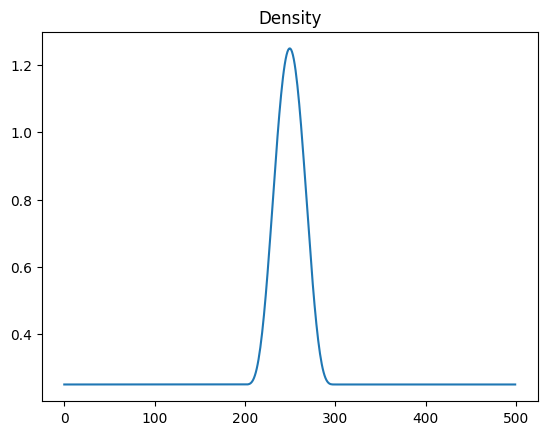

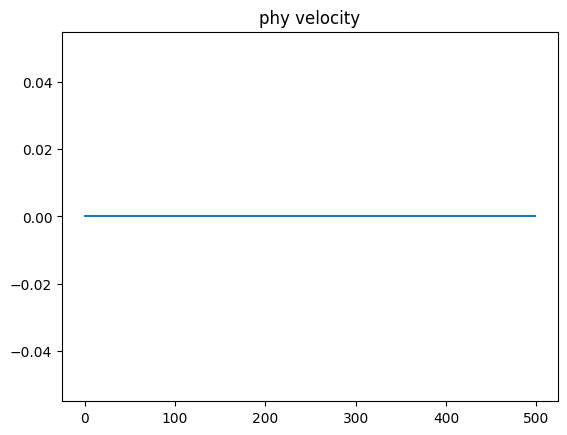

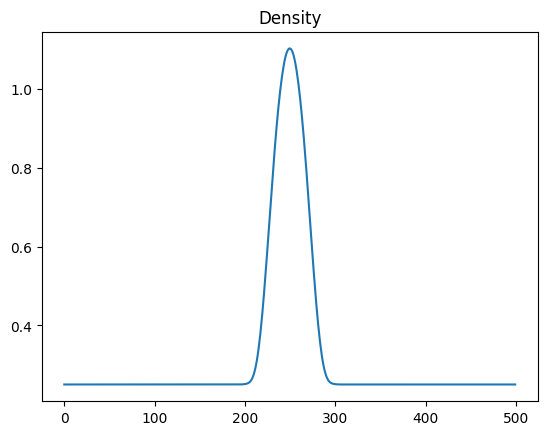

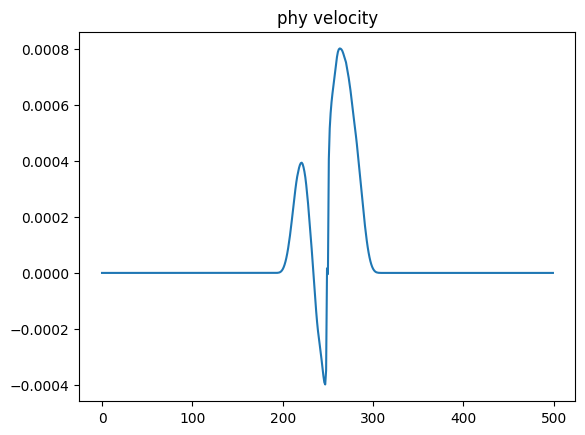

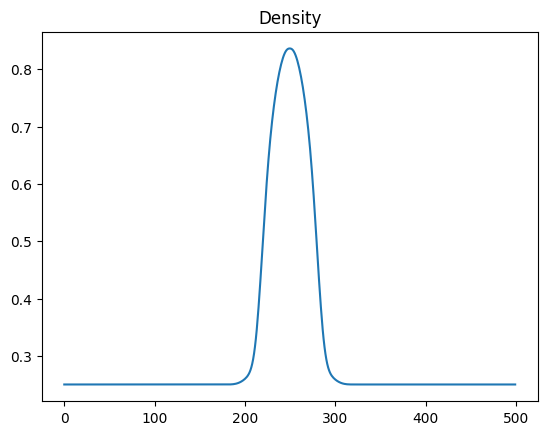

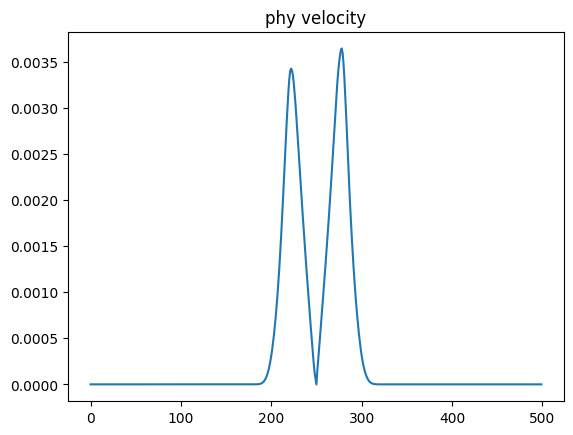

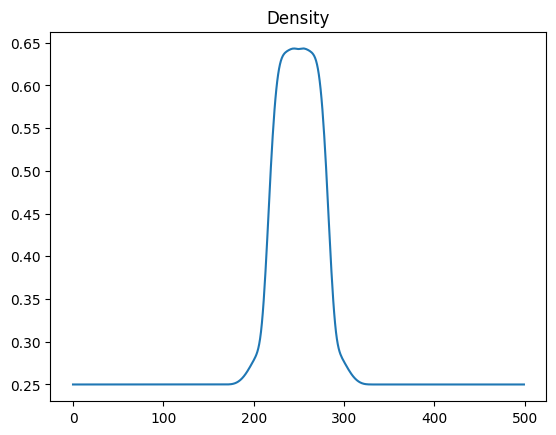

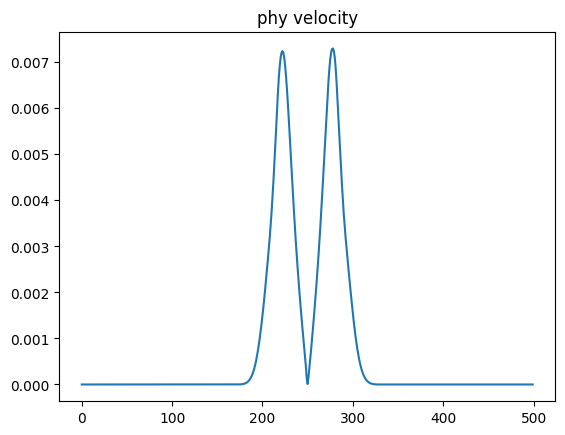

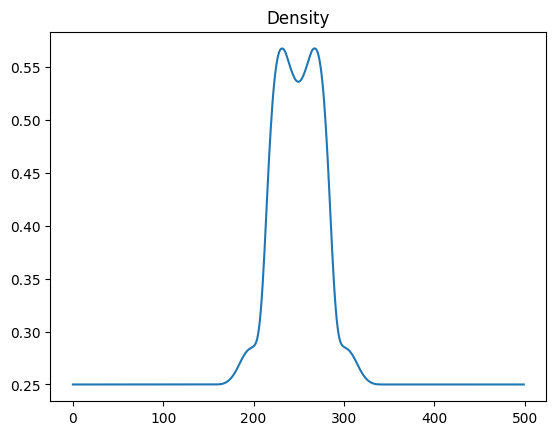

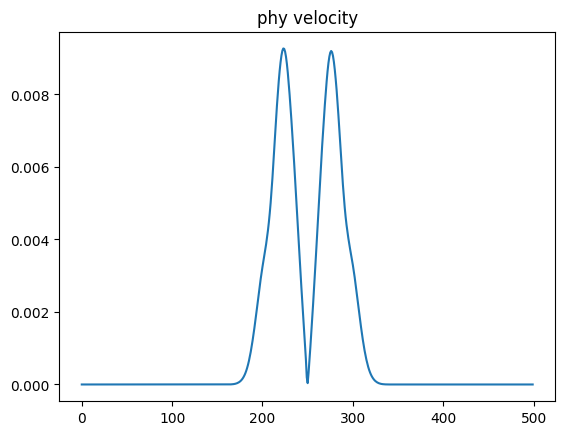

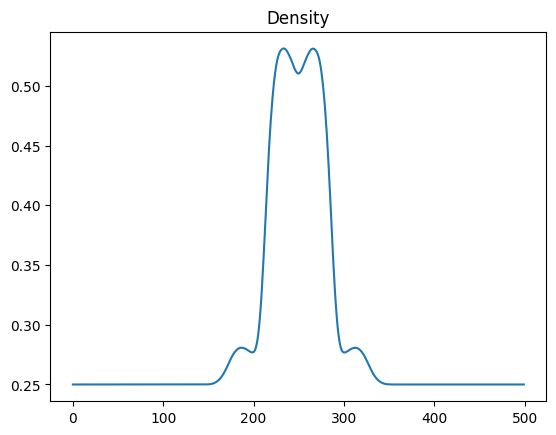

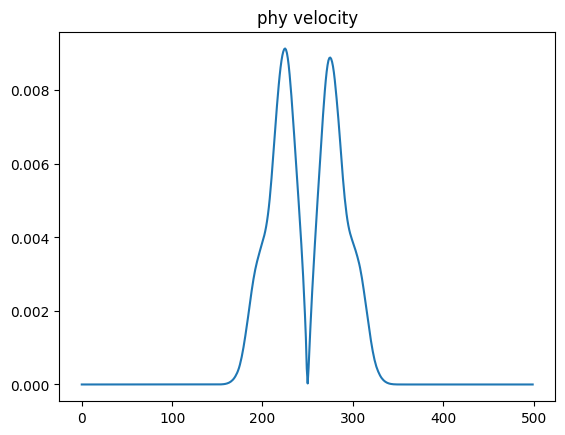

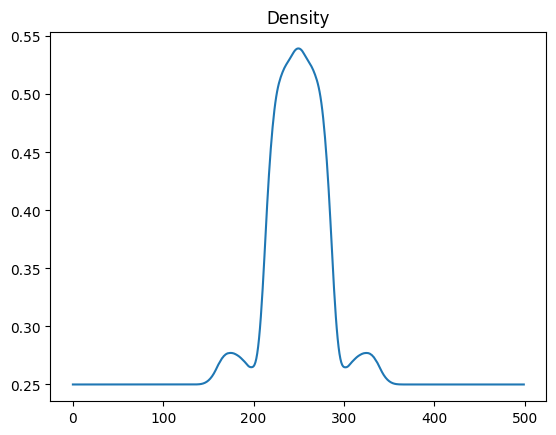

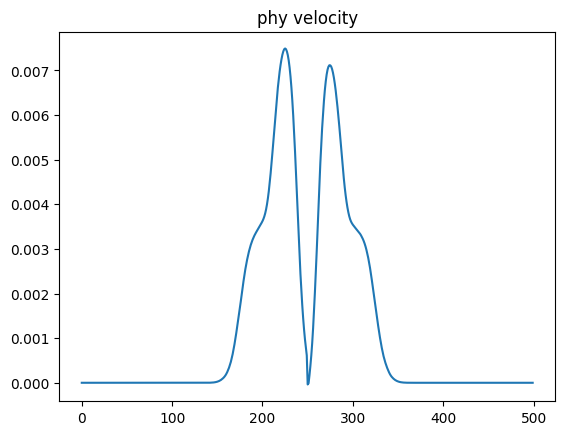

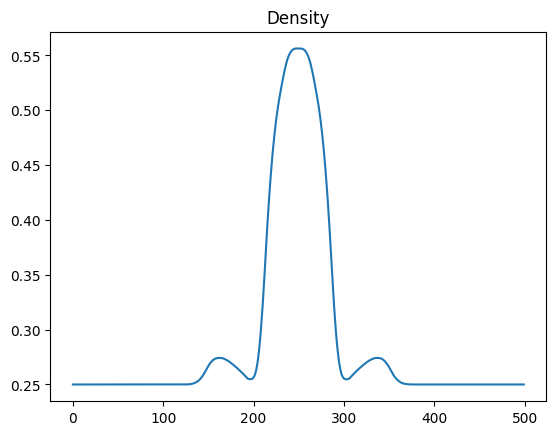

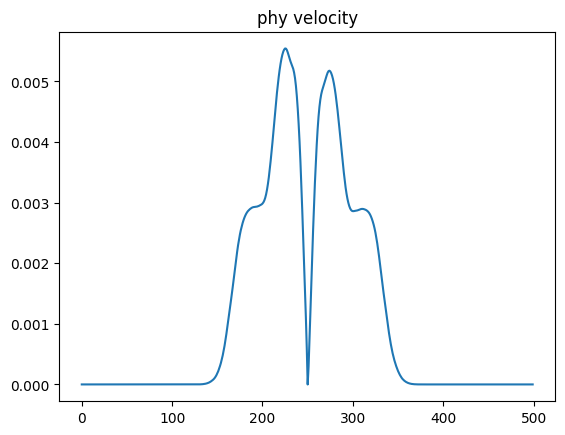

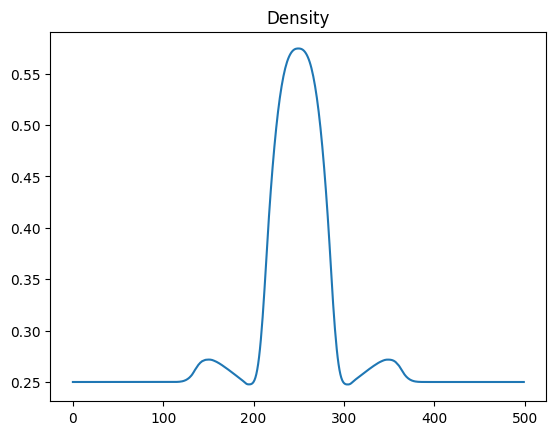

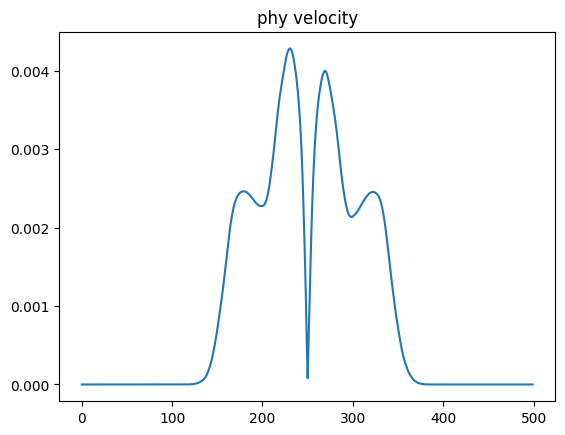

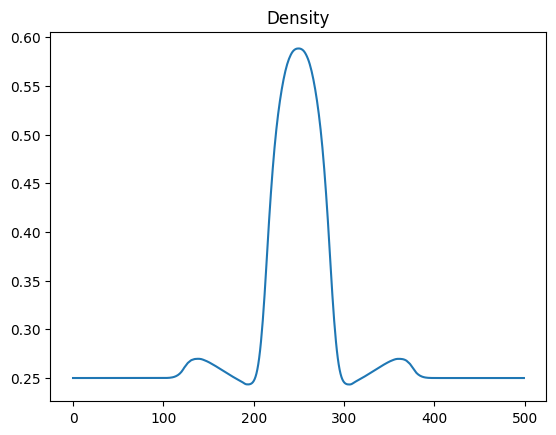

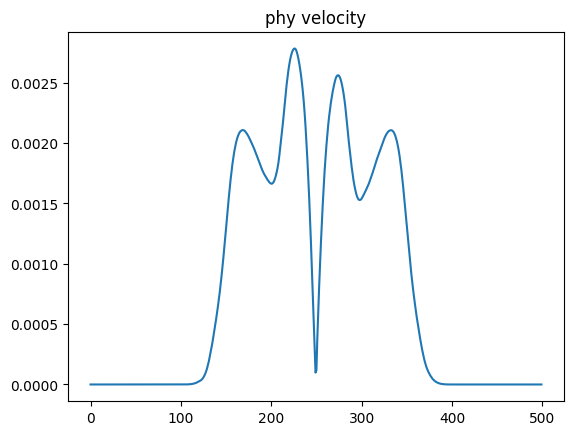

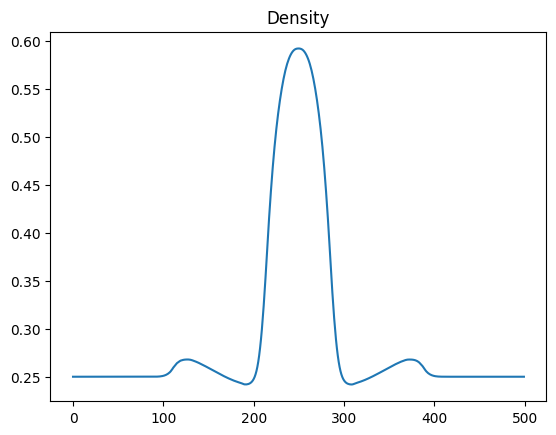

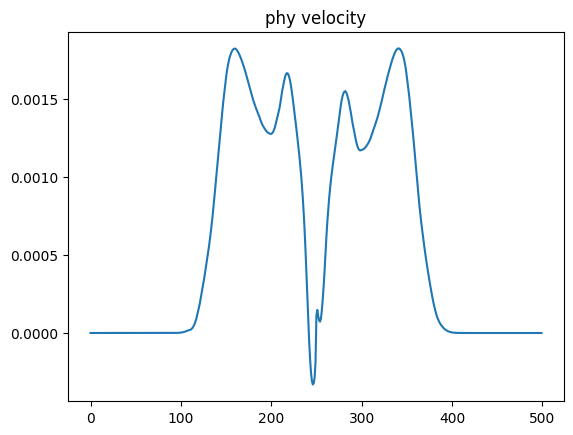

In [ ]:
i=0
while i < len(solution):
  rho = (solution[i][:N])[int(N/2)]
  ux = solution[i][N:2*N][int(N/2)]
  uy = solution[i][2*N:3*N][int(N/2)]
  Pi = solution[i][3*N:][int(N/2)]
  ur = np.sqrt(ux**2 + uy**2)
  uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])
  plt.plot(rho)
  plt.title('Density')
  plt.show()
  plt.title('phy velocity')
  plt.plot(uphy)
  plt.show()
  i += 10

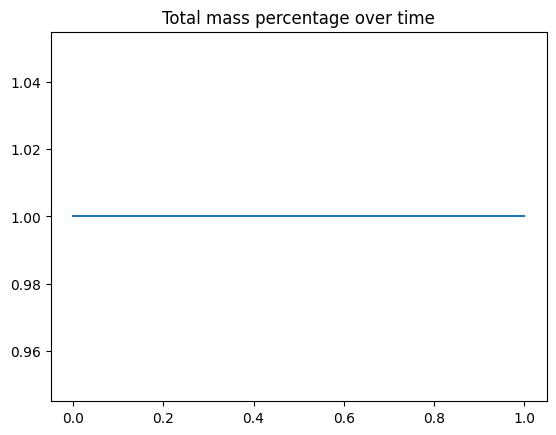

In [ ]:
plt.plot(tOut*np.array(range(len(mass))),mass/mass[0])
plt.title("Total mass percentage over time")
plt.show()

In [ ]:

t                      = 0   # s
tEnd                   = 1  # time at the end
tOut                   = 0.01 # time of each output

N                      = 300 # resolution
boxsize                = 1.  # in some unit system l
gamma                  = 5/3 # adiabatic index
zeta                   = 5 # bulk viscosity coefficient
eta                    = 5
tau_nu                 = 5
theta                  = 1


# Define Mesh
dx = boxsize / N   # box size
dy = dx
vol = dx**2        # volume of each box
#xlin = np.linspace(0.5*dx, (boxsize-0.5*dx), N)# simulation limits
xlin = np.linspace(0.5*dx,boxsize-0.5*dx, N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

w0 = 0.1
sigma = 0.05/np.sqrt(2.)
rho = 2. + (np.abs(Y-0.5) < 0.25)
vx = -2 + 3*(np.abs(Y-0.5) < 0.25)
vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
''' initial condition of Pi tensor '''
Pixx = np.zeros(s)
Pixy = np.zeros(s)
Piyx = np.zeros(s)
Piyy = np.zeros(s)

IC = np.vstack((rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example

sol, m = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, zeta, tau_nu, eta, theta))

0.00/1.00
0.01/1.00
0.02/1.00
0.03/1.00
0.04/1.00
0.05/1.00
0.06/1.00
0.07/1.00
0.08/1.00
0.09/1.00
0.10/1.00
0.11/1.00
0.12/1.00
0.13/1.00
0.14/1.00
0.15/1.00
0.16/1.00
0.17/1.00
0.18/1.00
0.19/1.00
0.20/1.00
0.21/1.00
0.22/1.00
0.23/1.00
0.24/1.00
0.25/1.00
0.26/1.00
0.27/1.00
0.28/1.00
0.29/1.00
0.30/1.00
0.31/1.00
0.32/1.00
0.33/1.00
0.34/1.00
0.35/1.00
0.36/1.00
0.37/1.00
0.38/1.00
0.39/1.00
0.40/1.00
0.41/1.00
0.42/1.00
0.43/1.00
0.44/1.00
0.45/1.00
0.46/1.00
0.47/1.00
0.48/1.00
0.49/1.00
0.50/1.00
0.51/1.00
0.52/1.00
0.53/1.00
0.54/1.00
0.55/1.00
0.56/1.00
0.57/1.00
0.58/1.00
0.59/1.00
0.60/1.00
0.61/1.00
0.62/1.00
0.63/1.00
0.64/1.00
0.65/1.00
0.66/1.00
0.67/1.00
0.68/1.00
0.69/1.00
0.70/1.00
0.71/1.00
0.72/1.00
0.73/1.00
0.74/1.00
0.75/1.00
0.76/1.00
0.77/1.00
0.78/1.00
0.79/1.00
0.80/1.00
0.81/1.00
0.82/1.00
0.83/1.00
0.84/1.00
0.85/1.00
0.86/1.00
0.87/1.00
0.88/1.00
0.89/1.00
0.90/1.00
0.91/1.00
0.92/1.00
0.93/1.00
0.94/1.00
0.95/1.00
0.96/1.00
0.97/1.00
0.98/1.00
0.99/1.00


In [ ]:
i=0
while i < len(sol):
    plt.cla()
    rho = sol[i][:N].T
    plt.imshow(rho)
    #plt.clim(0.8, 2.2)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i += 2
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

t                      = 0   # s
tEnd                   = 2  # time at the end
tOut                   = 0.01 # time of each output

N                      = 200 # resolution
boxsize                = 10.  # in some unit system l
gamma                  = 5/3 # adiabatic index
zeta                   = 1 # bulk viscosity coefficient
eta                    = 10
tau_nu                 = 1
theta                  = 1


# Define Mesh
dx = boxsize / N   # box size
dy = dx
vol = dx**2        # volume of each box
#xlin = np.linspace(0.5*dx, (boxsize-0.5*dx), N)# simulation limits
xlin = np.linspace(-0.5*(boxsize-0.5*dx),0.5*(boxsize-0.5*dx), N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

w0 = 0.1
sigma = 0.05/np.sqrt(2.)
rho = 0.5 + 0.25*np.sin(2*np.pi*R)*(R<1)
vx = np.zeros(s)
vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
''' initial condition of Pi tensor '''
Pixx = np.zeros(s)
Pixy = np.zeros(s)
Piyx = np.zeros(s)
Piyy = np.zeros(s)

IC = np.vstack((rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example

sol1, m = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, zeta, tau_nu, eta, theta))

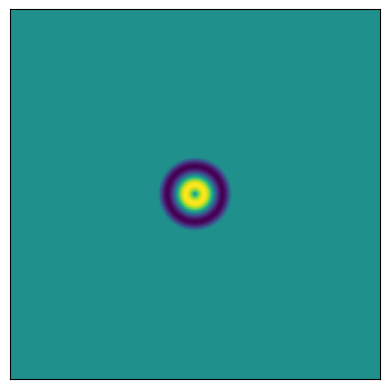

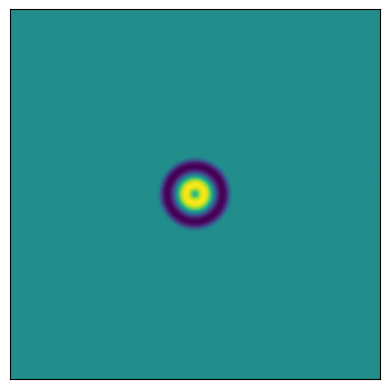

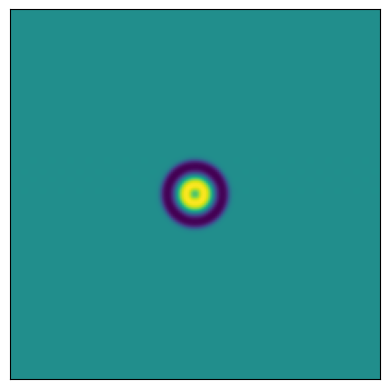

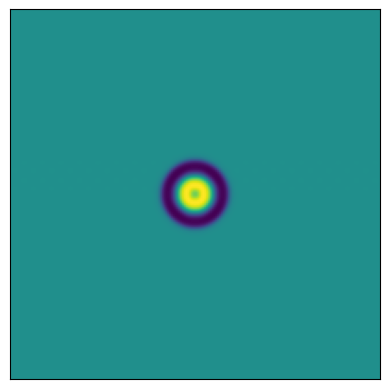

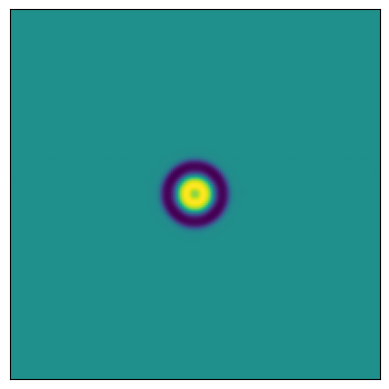

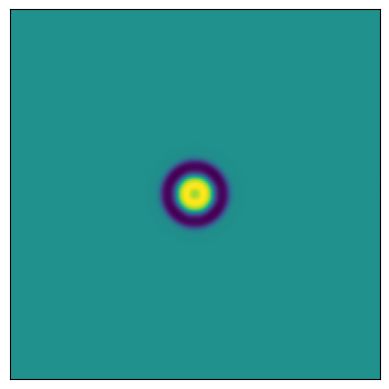

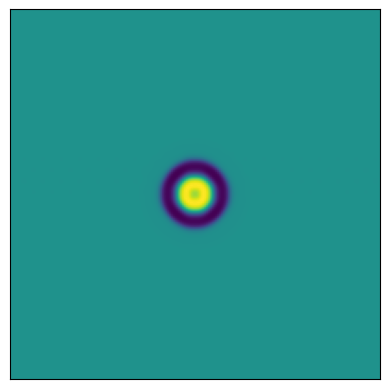

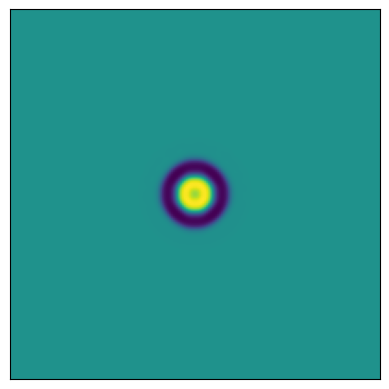

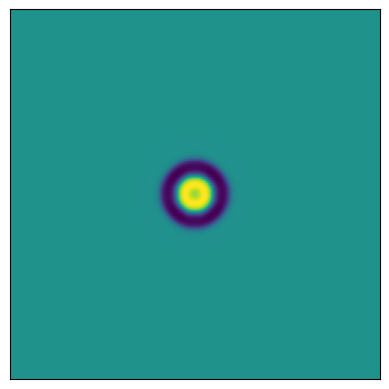

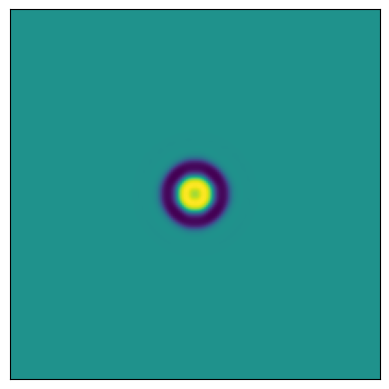

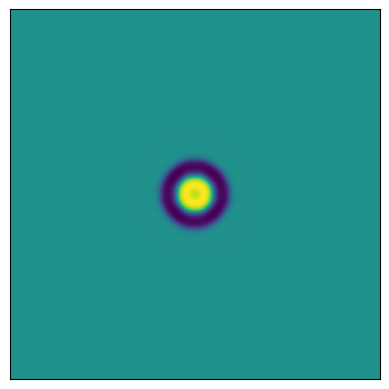

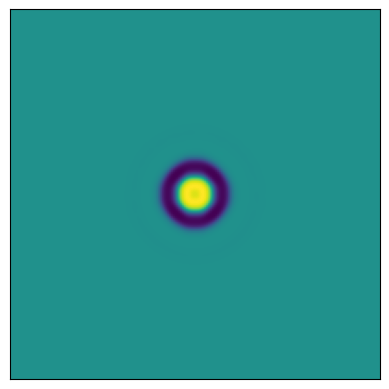

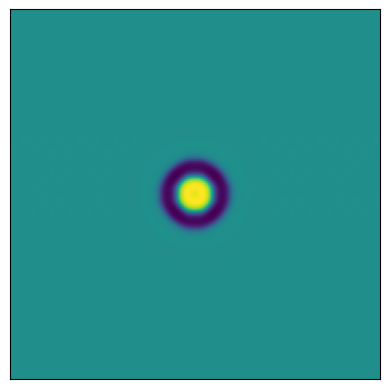

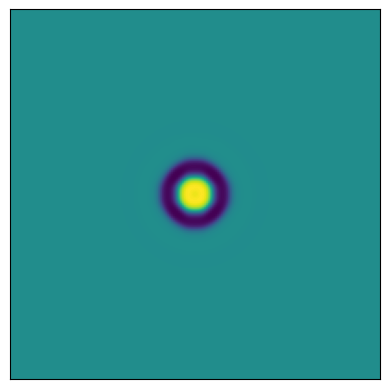

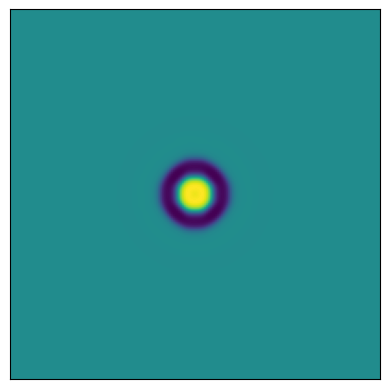

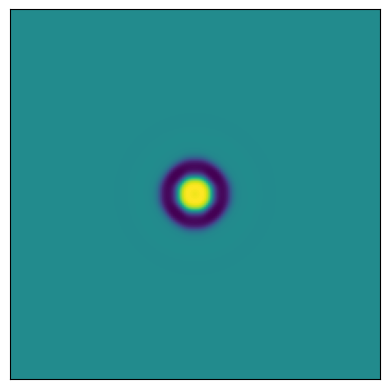

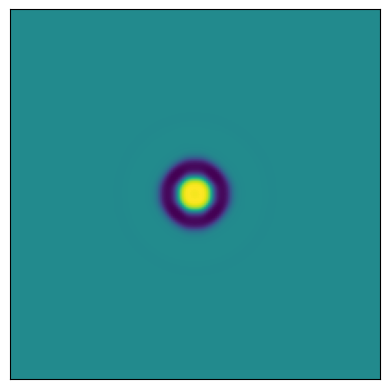

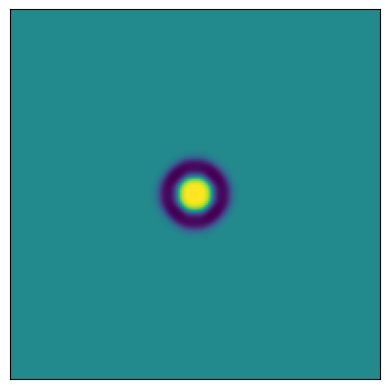

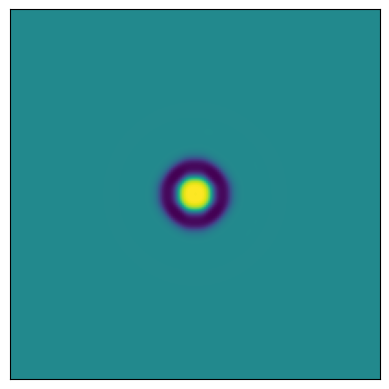

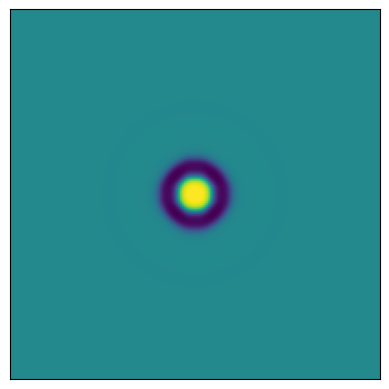

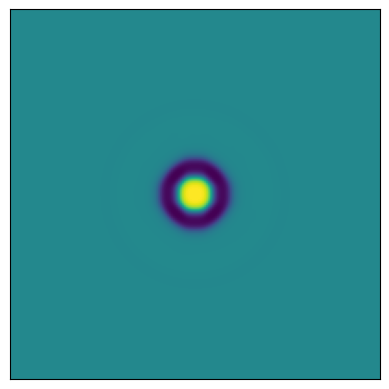

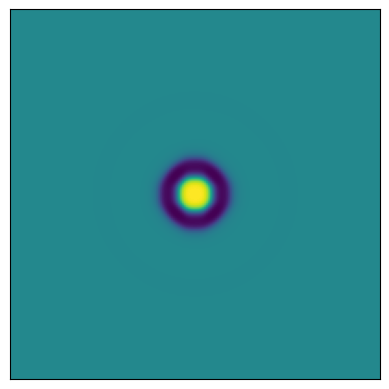

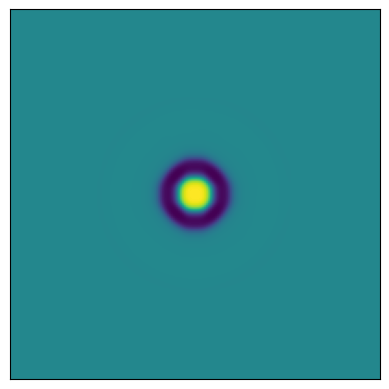

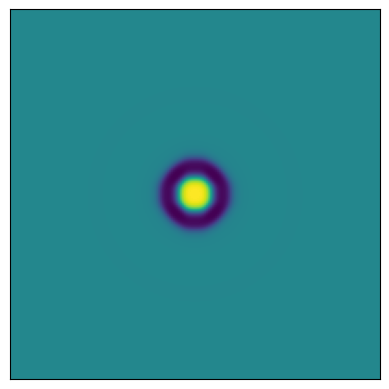

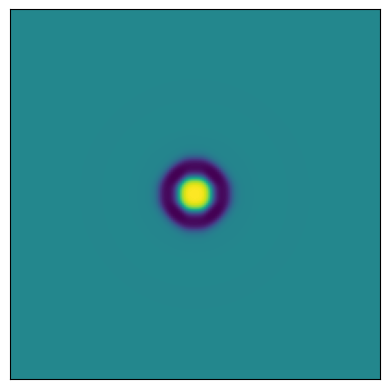

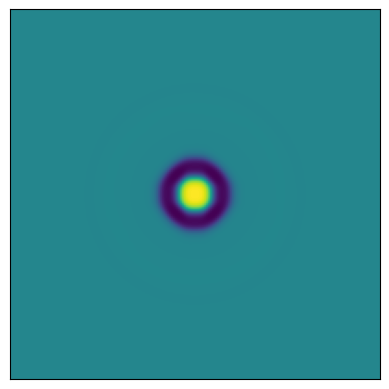

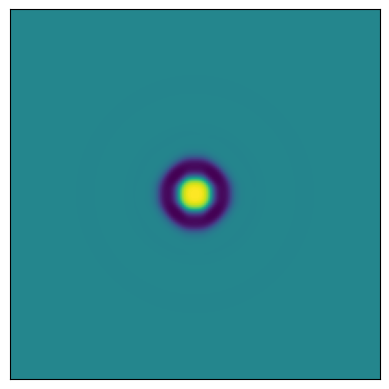

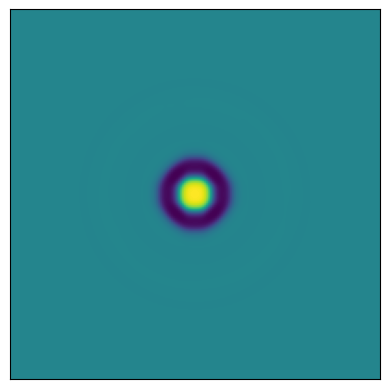

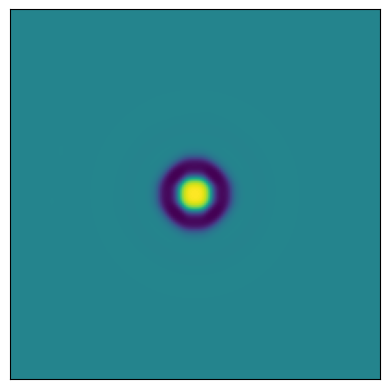

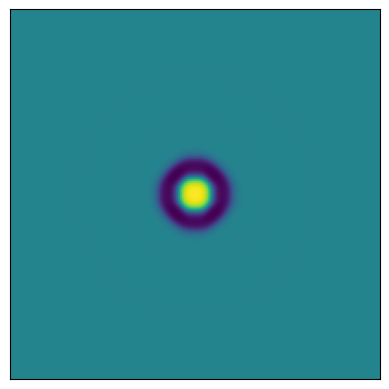

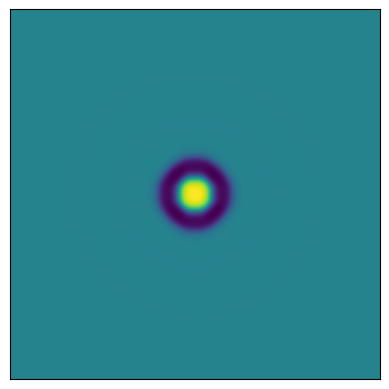

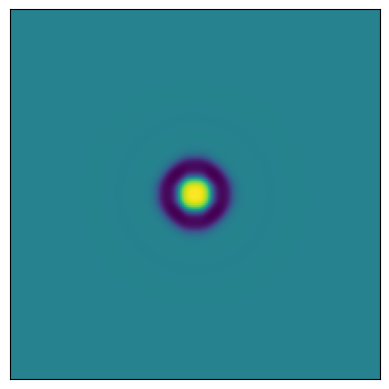

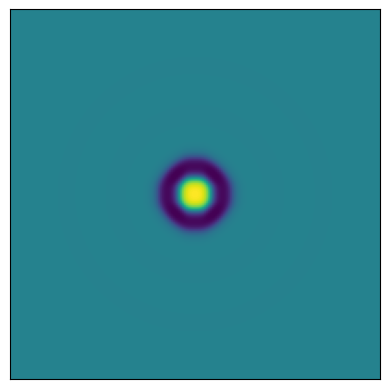

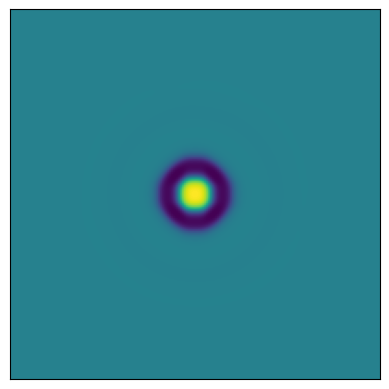

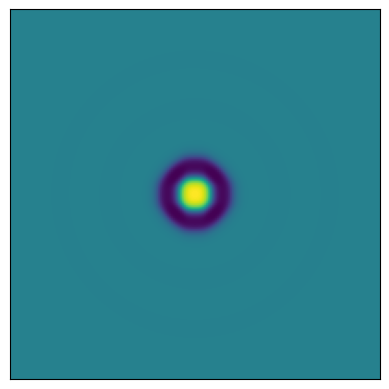

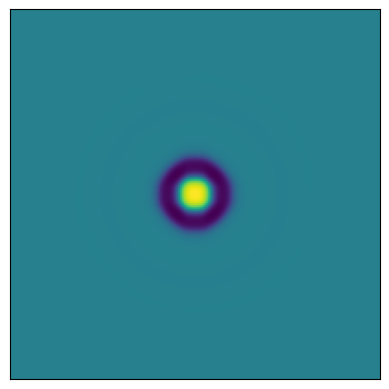

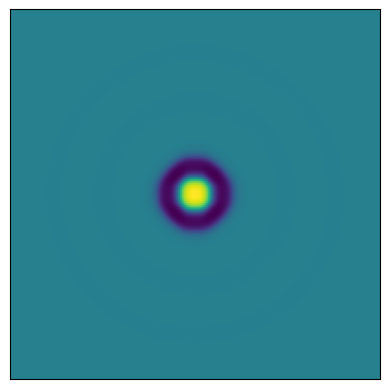

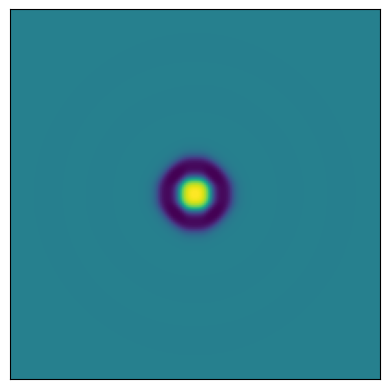

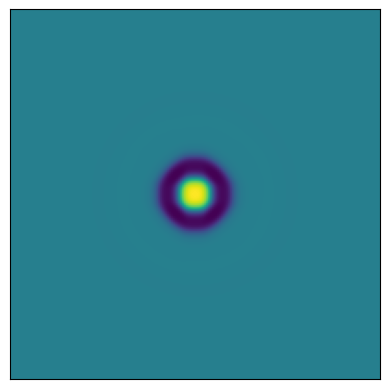

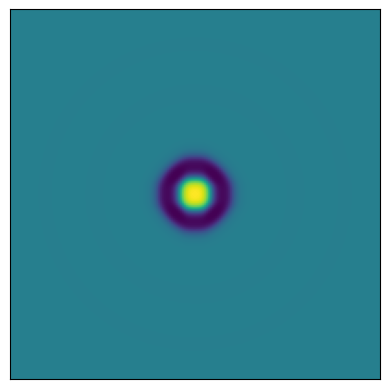

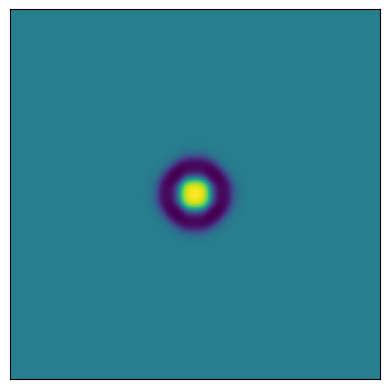

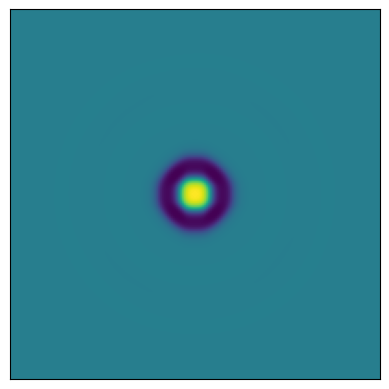

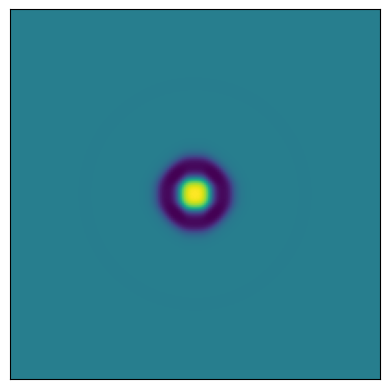

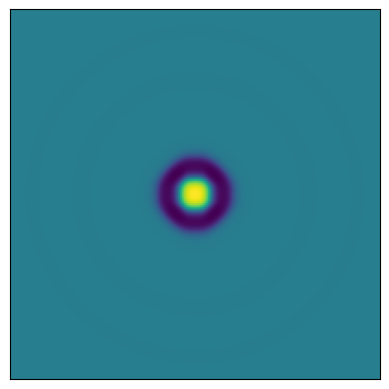

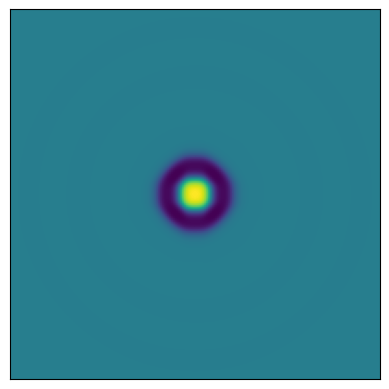

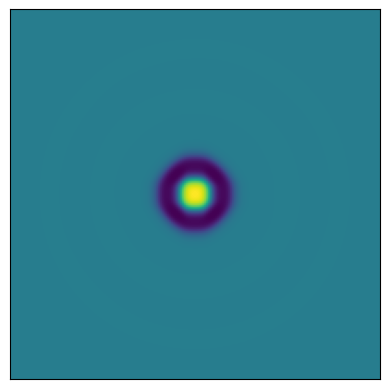

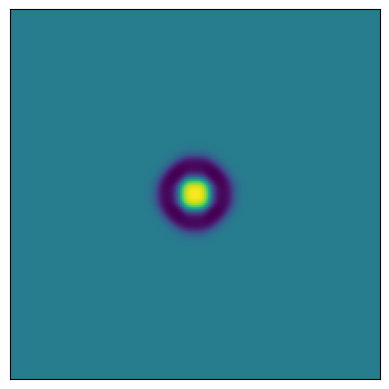

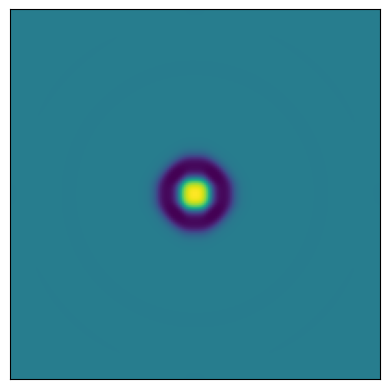

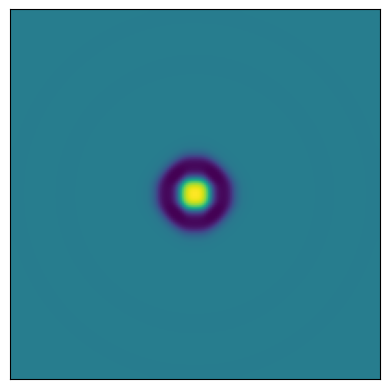

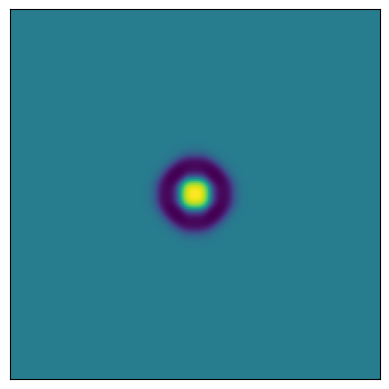

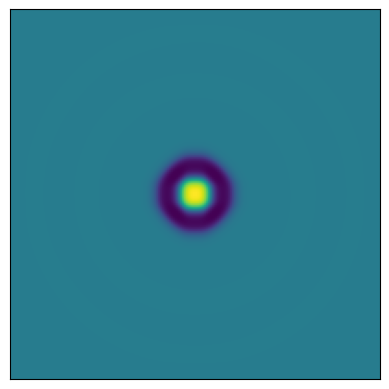

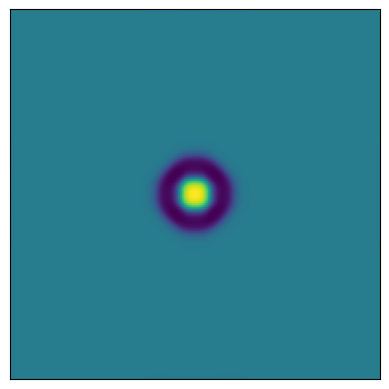

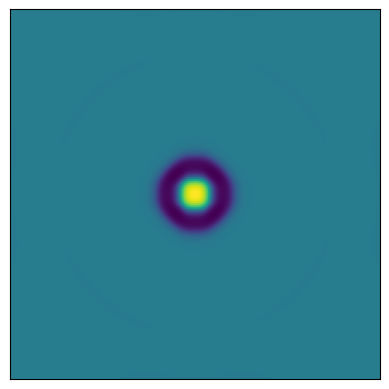

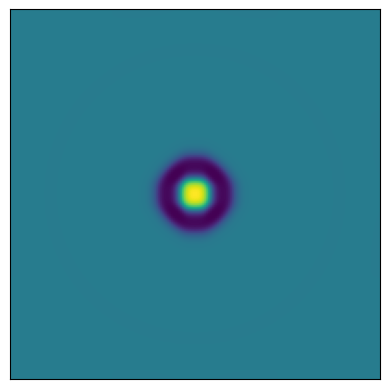

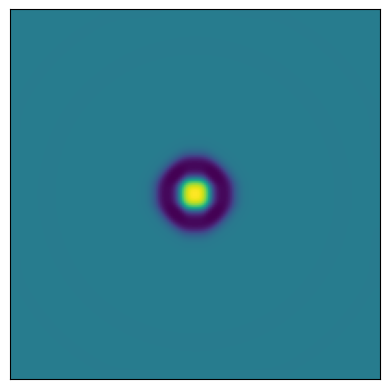

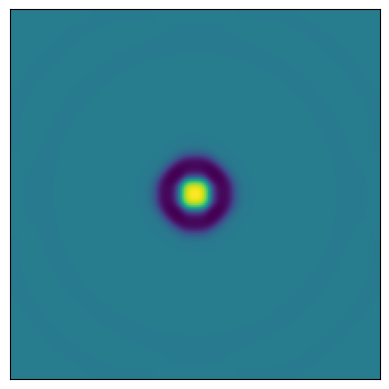

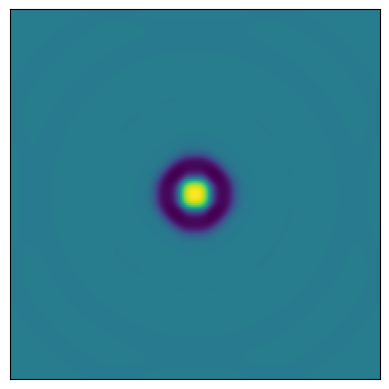

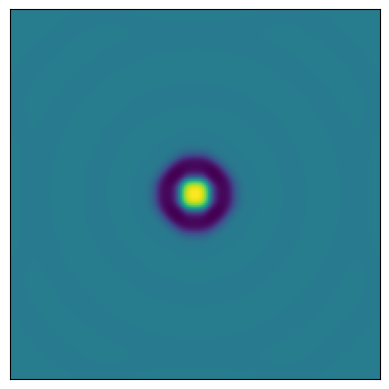

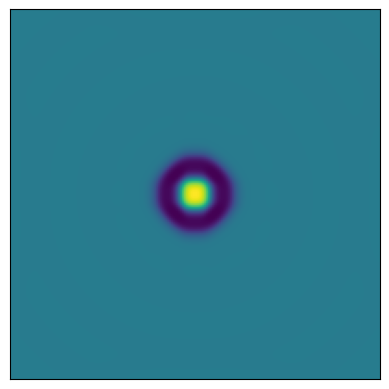

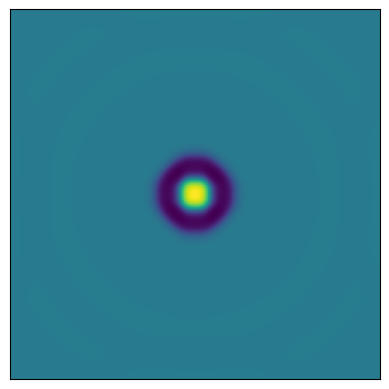

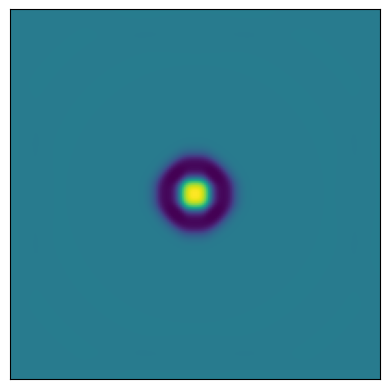

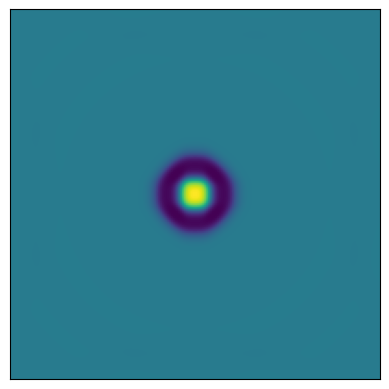

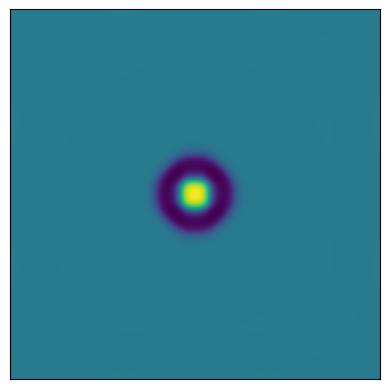

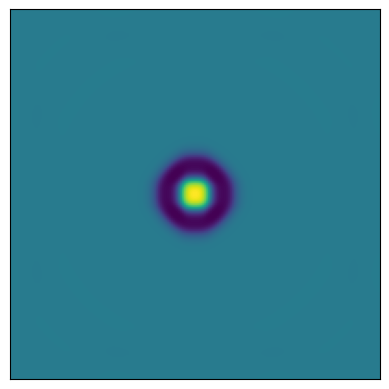

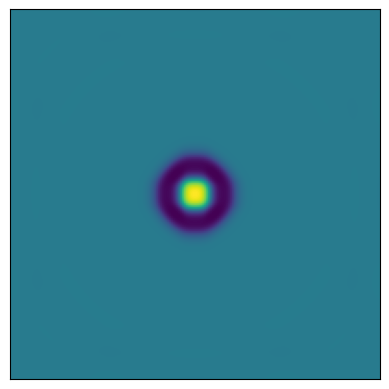

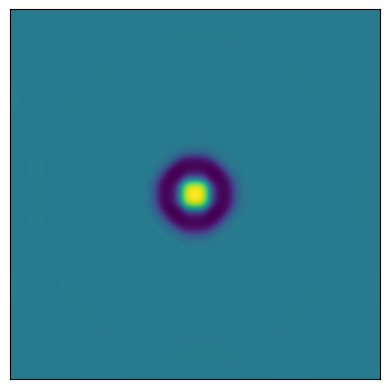

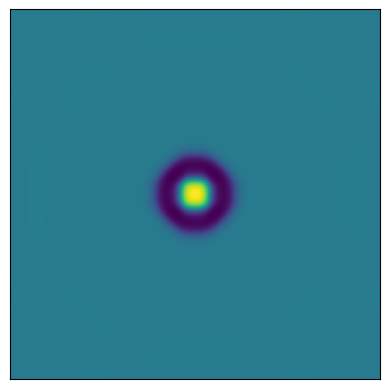

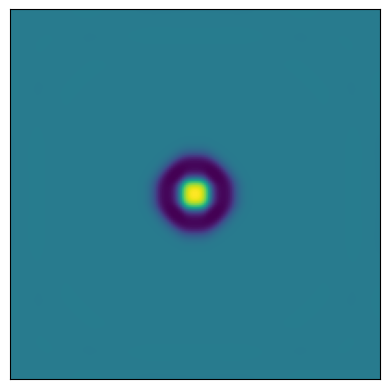

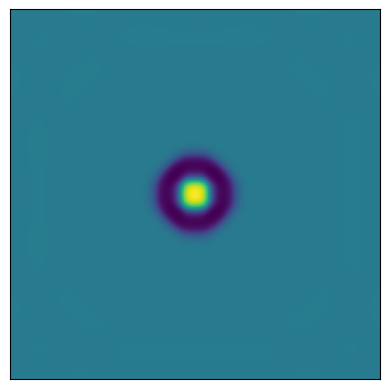

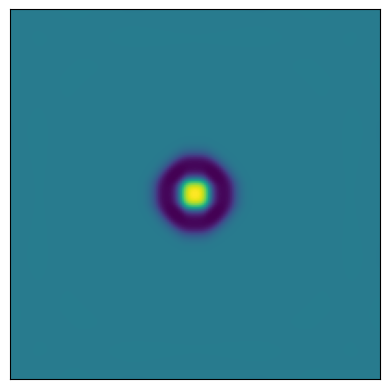

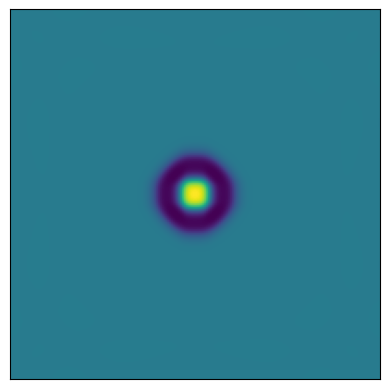

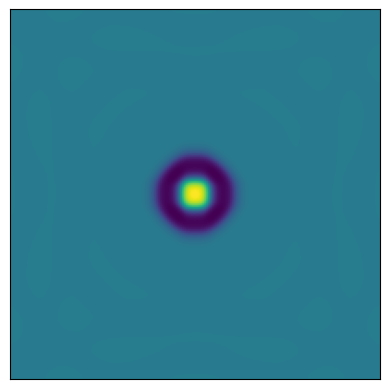

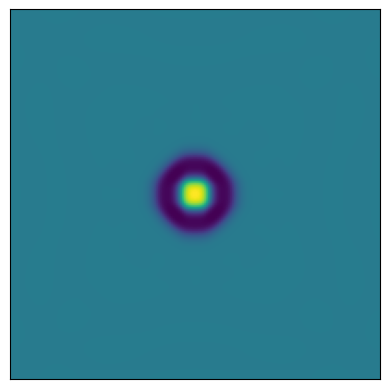

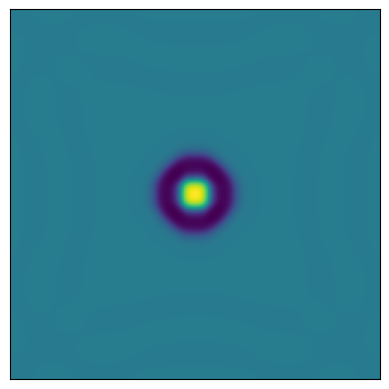

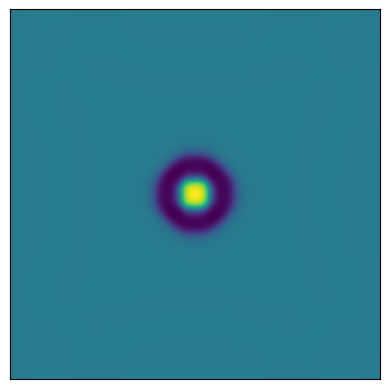

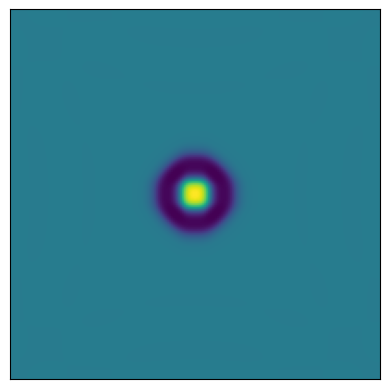

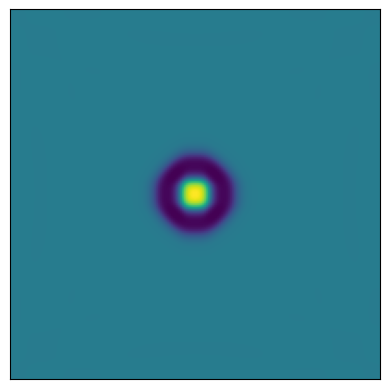

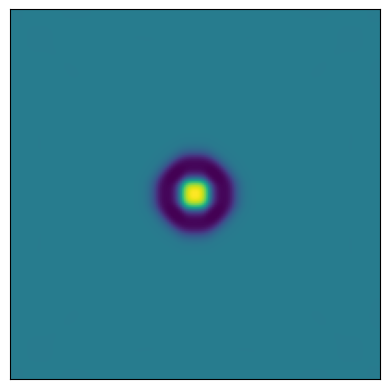

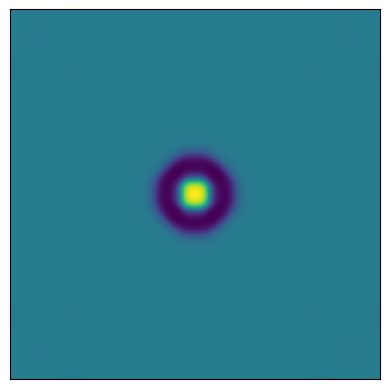

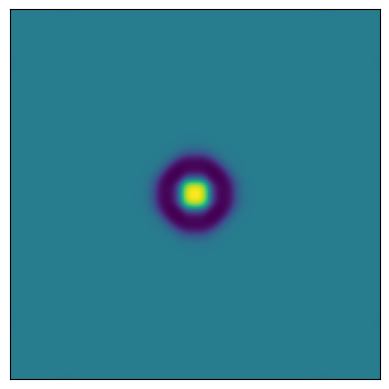

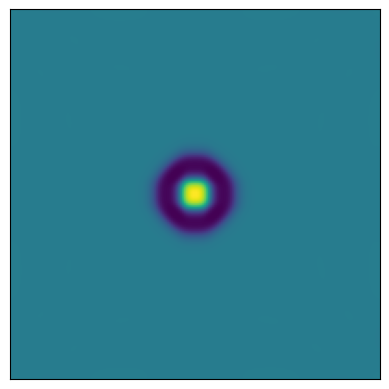

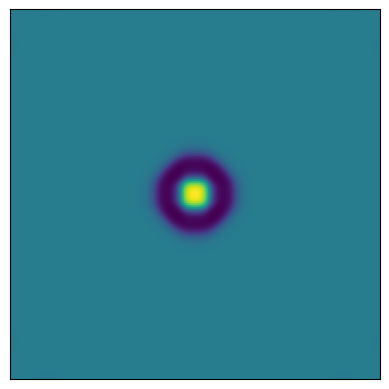

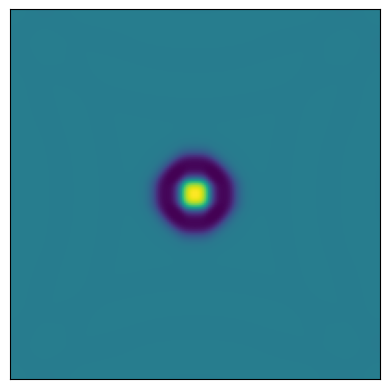

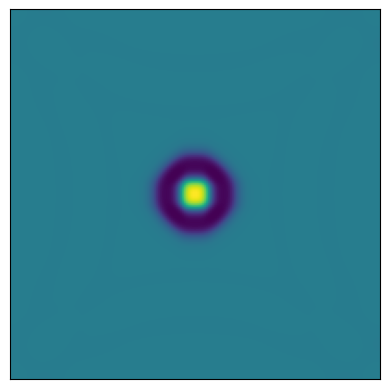

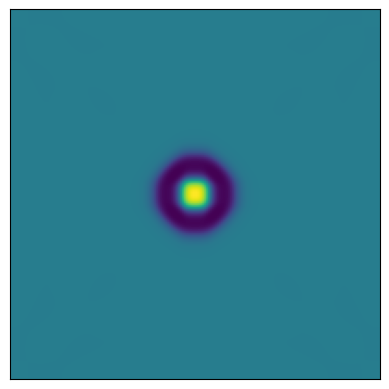

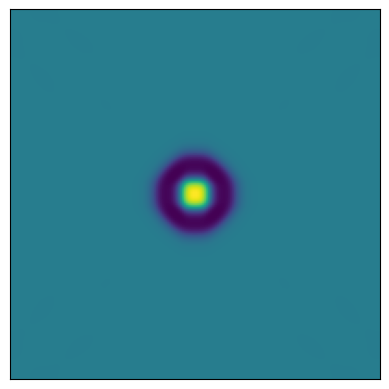

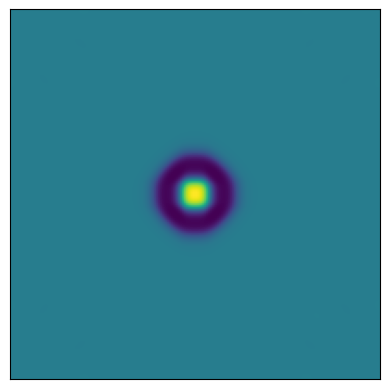

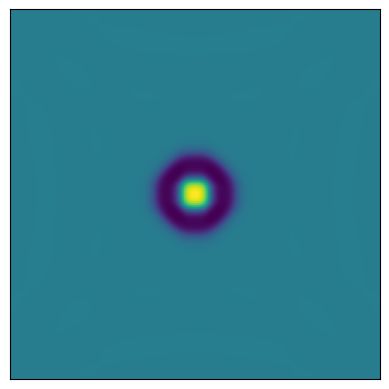

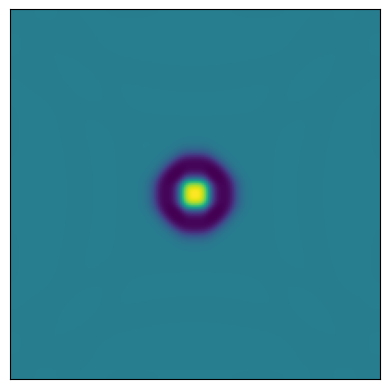

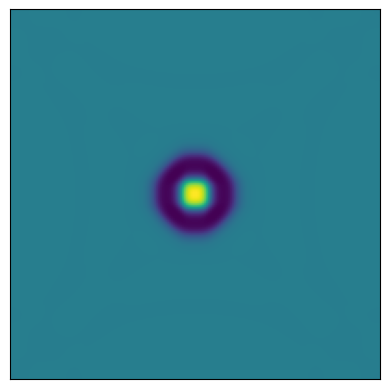

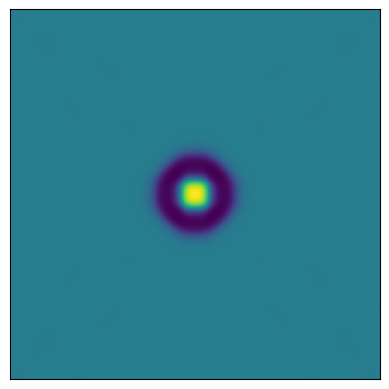

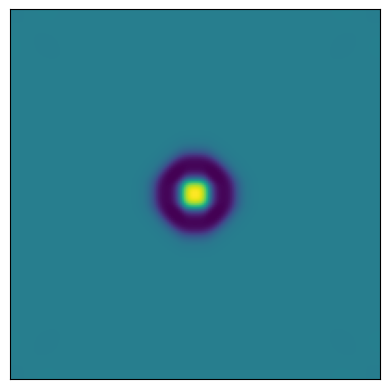

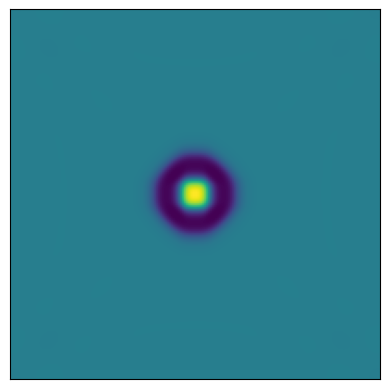

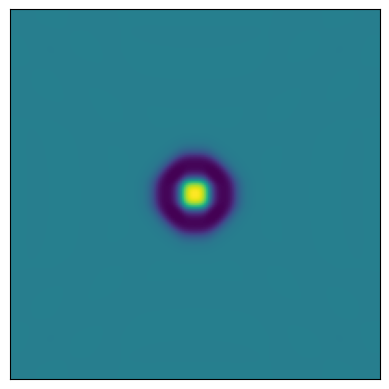

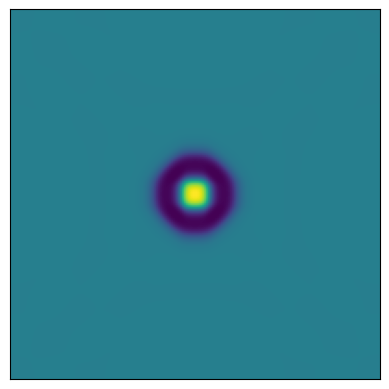

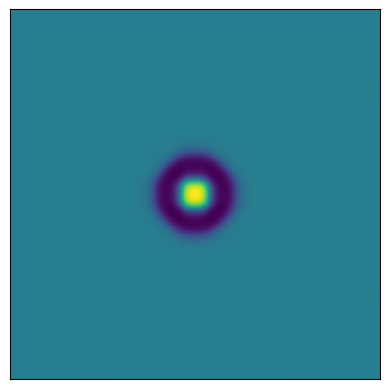

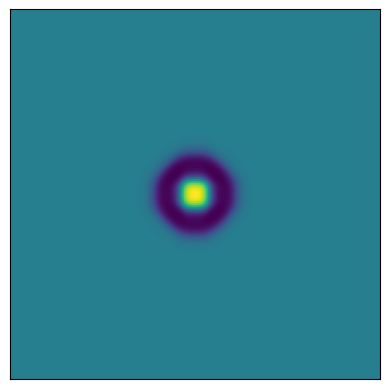

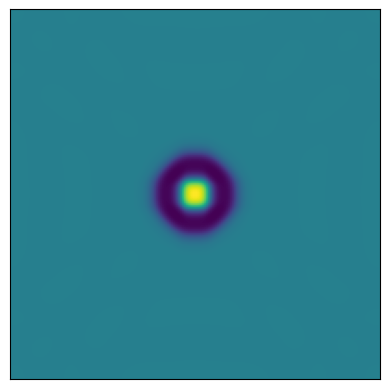

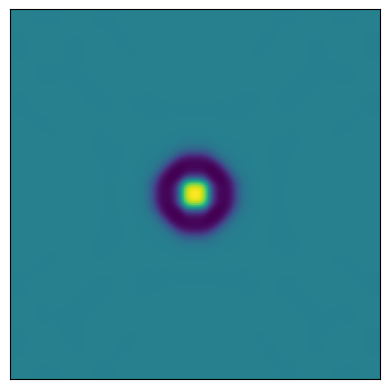

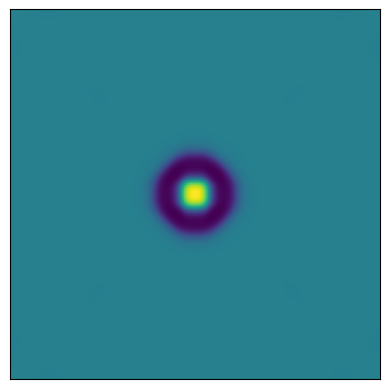

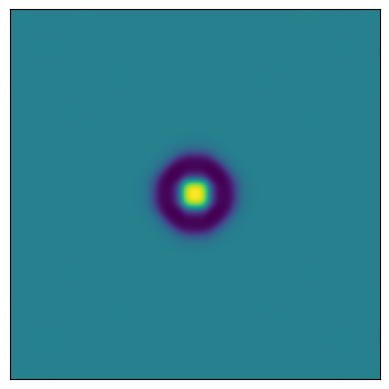

In [ ]:
i=0
while i < len(sol1):
    plt.cla()
    rho = sol1[i][:N].T
    plt.imshow(rho)
    #plt.clim(0.8, 2.2)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i += 2
plt.show()

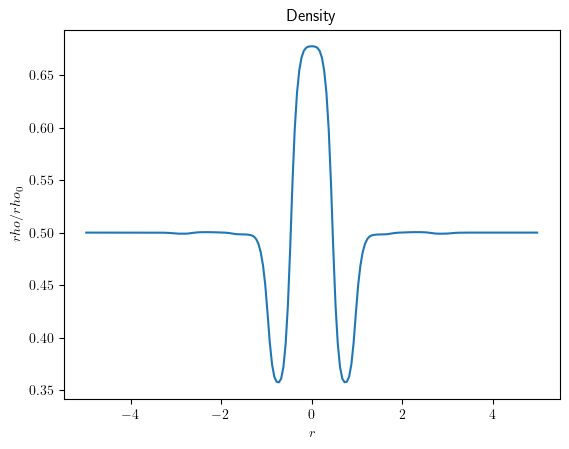

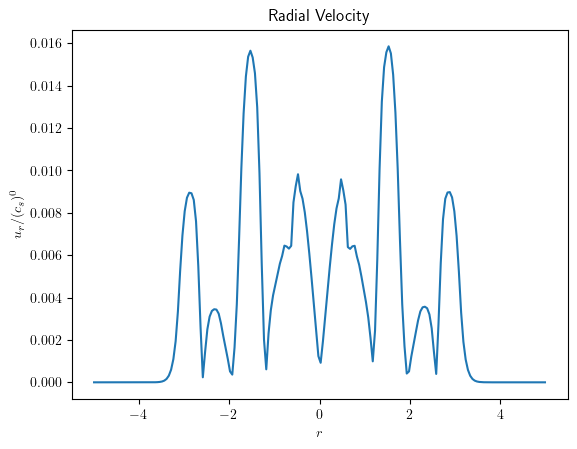

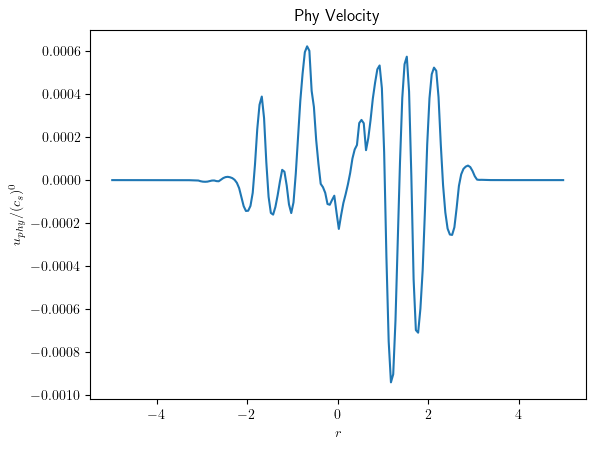

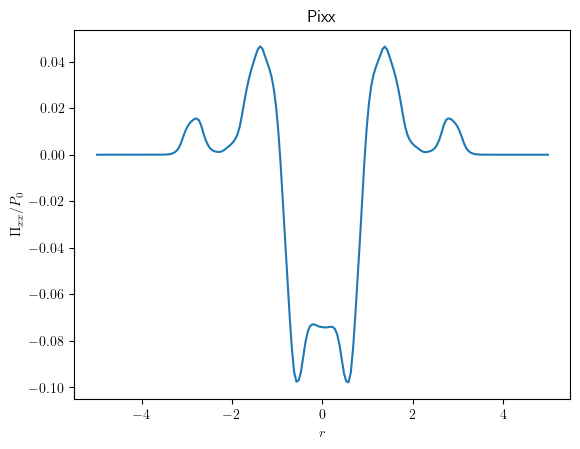

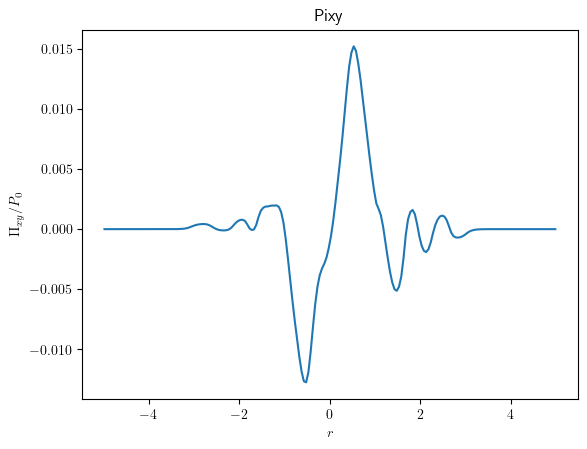

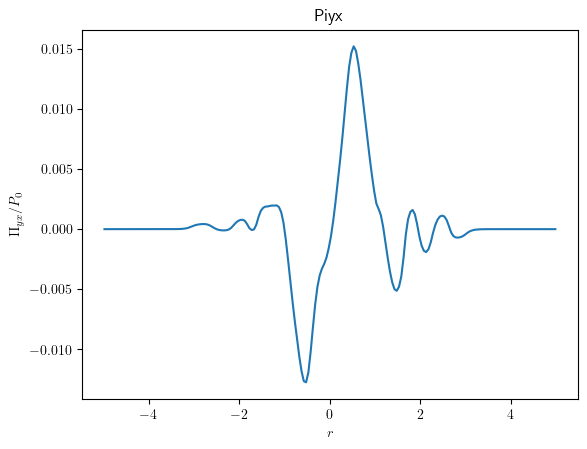

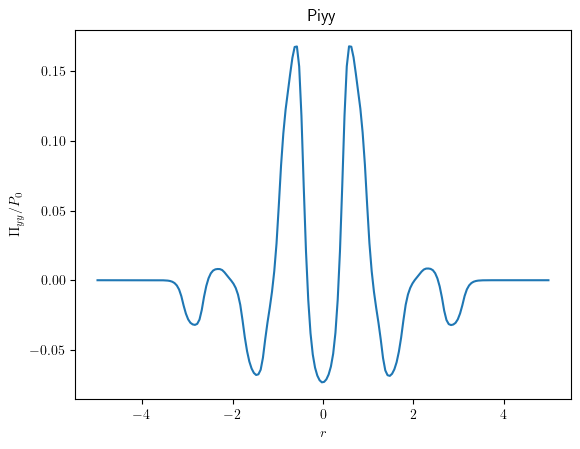

In [ ]:

i=50

# slice through the center horizontally
rho = (sol1[i][:N])[int(N/2)]
ux = sol1[i][N:2*N][int(N/2)] / rho
uy = sol1[i][2*N:3*N][int(N/2)] / rho
Pixx = sol1[i][3*N:4*N][int(N/2)]
Pixy = sol1[i][4*N:5*N][int(N/2)]
Piyx = sol1[i][5*N:6*N][int(N/2)]
Piyy = sol1[i][6*N:][int(N/2)]

ur = np.sqrt(ux**2 + uy**2)
uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])


plt.plot(xlin,rho)
plt.title('Density')
plt.xlabel("$r$")
plt.ylabel("$rho/rho_0$")
plt.show()


plt.plot(xlin,ur)
plt.title('Radial Velocity')
plt.xlabel("$r$")
plt.ylabel("$u_r/(c_s)^{0}$")
plt.show()


plt.plot(xlin,uphy)
plt.title('Phy Velocity')
plt.xlabel("$r$")
plt.ylabel("$u_{phy}/(c_s)^{0}$")
plt.show()

plt.plot(xlin,Pixx)
plt.title('Pixx')
plt.xlabel("$r$")
plt.ylabel("$\Pi_{xx}/P_0$")
plt.show()

plt.plot(xlin, Pixy)
plt.title('Pixy')
plt.xlabel("$r$")
plt.ylabel("$\Pi_{xy}/P_0$")
plt.show()

plt.plot(xlin, Piyx)
plt.title('Piyx')
plt.xlabel("$r$")
plt.ylabel("$\Pi_{yx}/P_0$")
plt.show()

plt.plot(xlin, Piyy)
plt.title('Piyy')
plt.xlabel("$r$")
plt.ylabel("$\Pi_{yy}/P_0$")
plt.show()

In [11]:

t                      = 0    # s
tEnd                   = 0.5  # time at the end
tOut                   = 0.01 # time of each output
N                      = 2**8 # resolution
boxsize                = 10.  # in some unit system l
gamma                  = 5/3  # adiabatic index
zeta                   = 1    # bulk viscosity coefficient
eta                    = 10   # shear viscosity
tau_nu                 = 1    # relaxation time
theta                  = 1    # flux limiter variable (1<theta<2)
b                      = 0.1  # impact parameter

# Define Mesh
dx = boxsize / N   # box size
dy = dx
vol = dx**2        # volume of each box
#xlin = np.linspace(0.5*dx, (boxsize-0.5*dx), N)# simulation limits
xlin = np.linspace(-0.5*(boxsize-0.5*dx),0.5*(boxsize-0.5*dx), N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R1 = np.sqrt((X-2*np.ones(s))**2 + (Y-b*np.ones(s))**2)
R2 = np.sqrt((X+2*np.ones(s))**2 + (Y+b*np.ones(s))**2)

rho = ((1 - R2**2 )**4)*(R2 < 1) + ((1 - R1**2 )**4)*(R1 < 1) + 0.5*np.ones(s)
vx =  15*np.ones(s) * (R2 < 1) - 15*np.ones(s) * (R1 < 1)
vy =  np.zeros(s)
''' initial condition of Pi tensor '''
Pixx = np.zeros(s)
Pixy = np.zeros(s)
Piyx = np.zeros(s)
Piyy = np.zeros(s)

IC = np.vstack((rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example

sol, m = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, zeta, tau_nu, eta, theta))

0.00/0.50
0.01/0.50
0.02/0.50
0.03/0.50
0.04/0.50
0.05/0.50
0.06/0.50
0.07/0.50
0.08/0.50
0.09/0.50
0.10/0.50
0.11/0.50
0.12/0.50
0.13/0.50
0.14/0.50
0.15/0.50
0.16/0.50
0.17/0.50
0.18/0.50
0.19/0.50
0.20/0.50
0.21/0.50
0.22/0.50
0.23/0.50
0.24/0.50
0.25/0.50
0.26/0.50
0.27/0.50
0.28/0.50
0.29/0.50
0.30/0.50
0.31/0.50
0.32/0.50
0.33/0.50
0.34/0.50
0.35/0.50
0.36/0.50
0.37/0.50
0.38/0.50
0.39/0.50
0.40/0.50
0.41/0.50
0.42/0.50
0.43/0.50
0.44/0.50
0.45/0.50
0.46/0.50
0.47/0.50
0.48/0.50
0.49/0.50
0.50/0.50


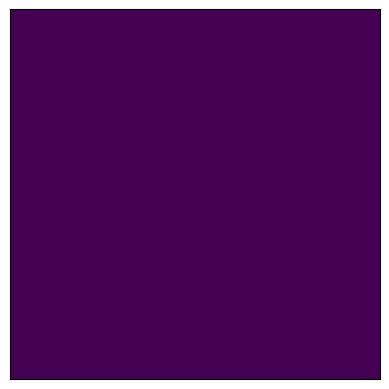

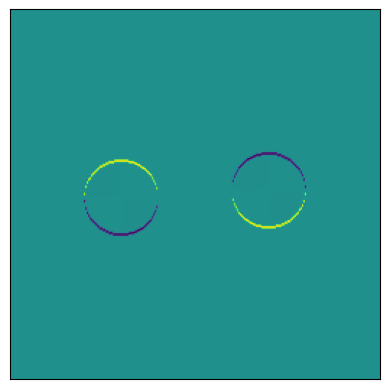

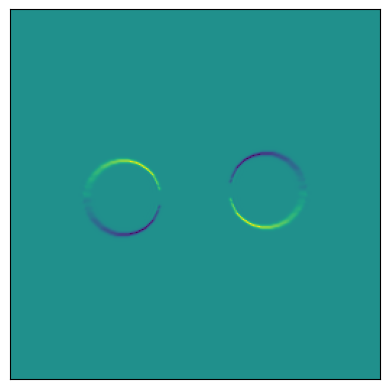

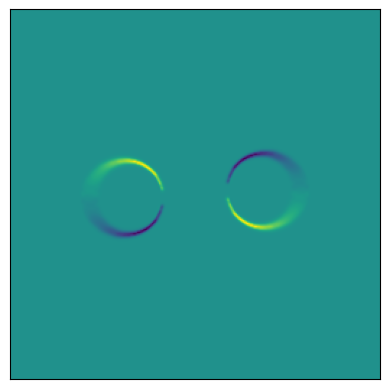

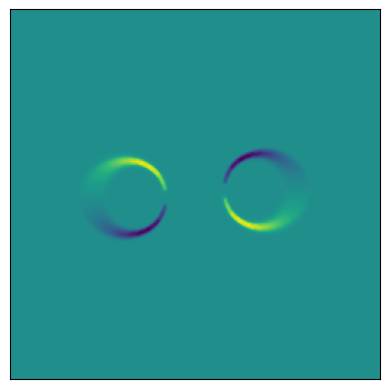

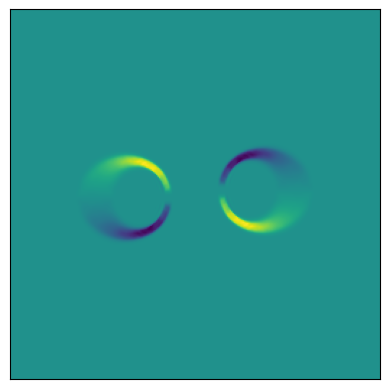

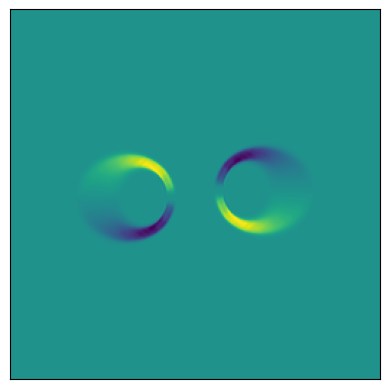

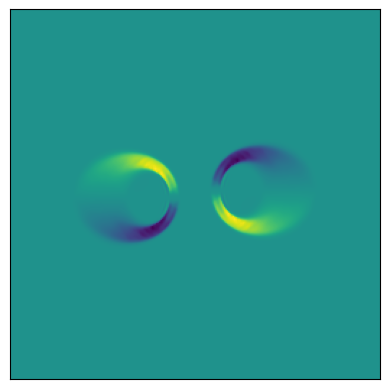

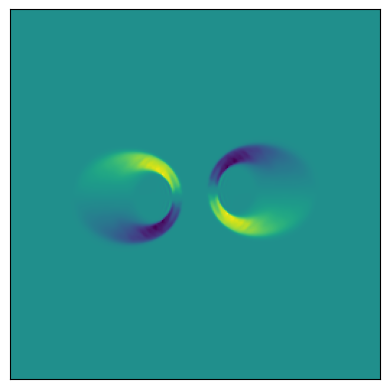

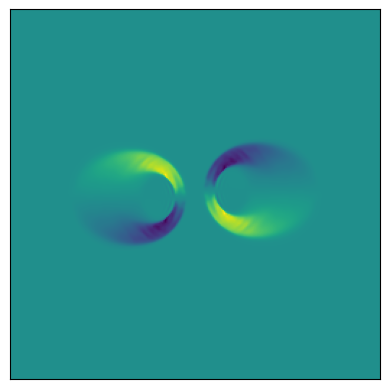

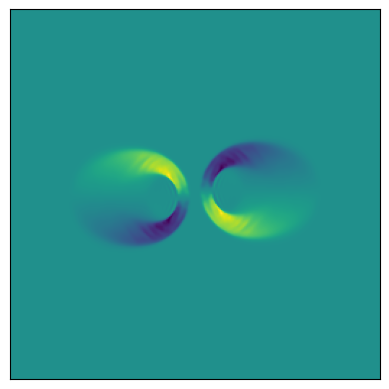

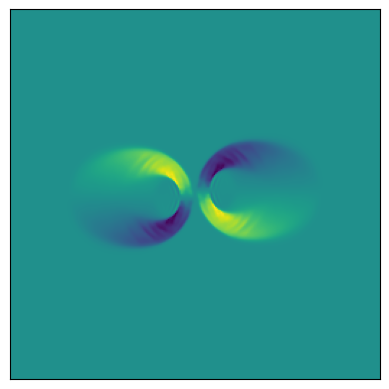

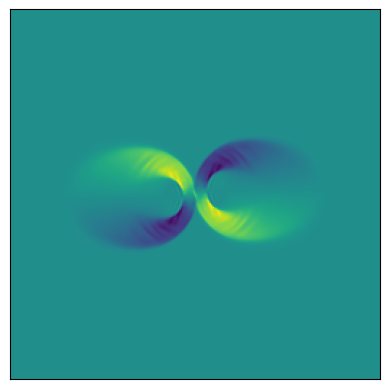

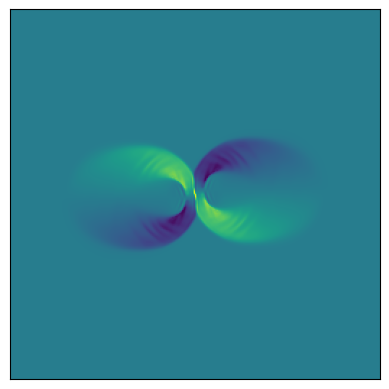

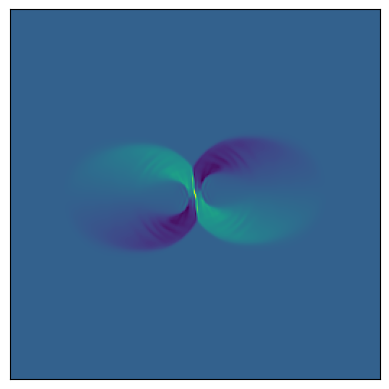

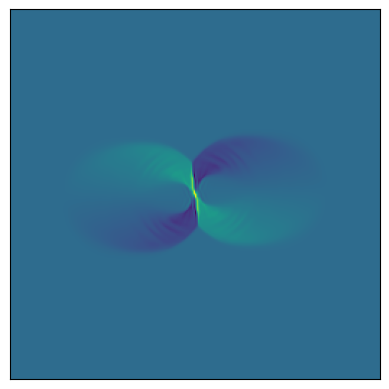

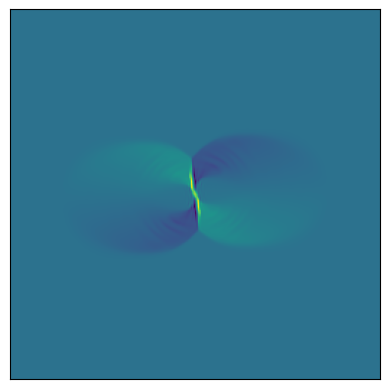

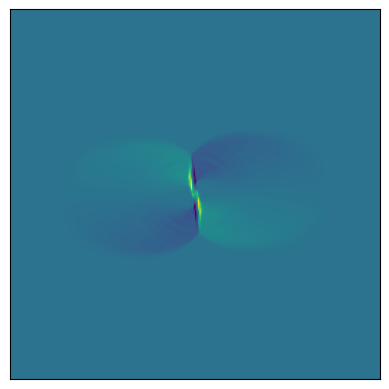

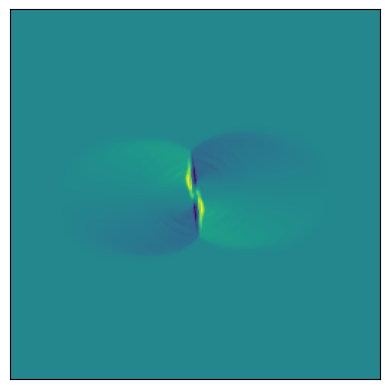

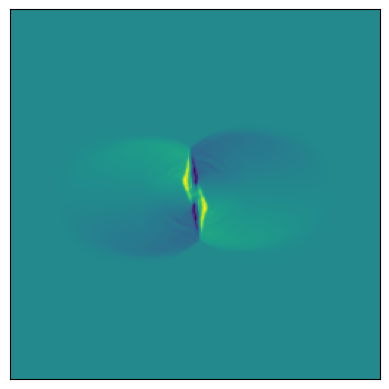

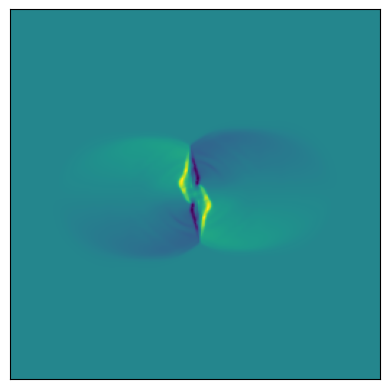

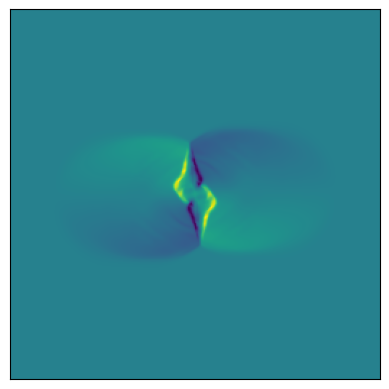

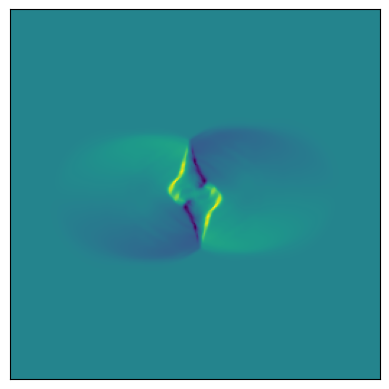

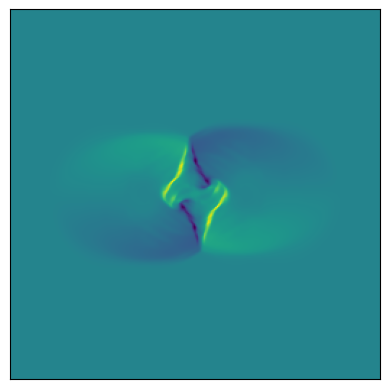

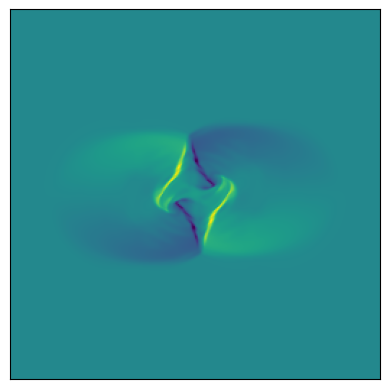

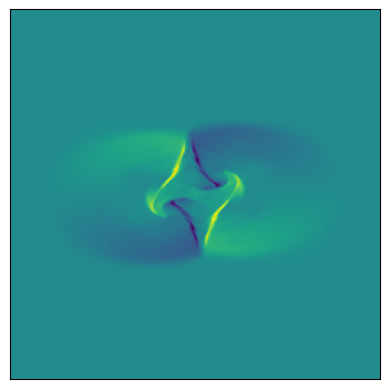

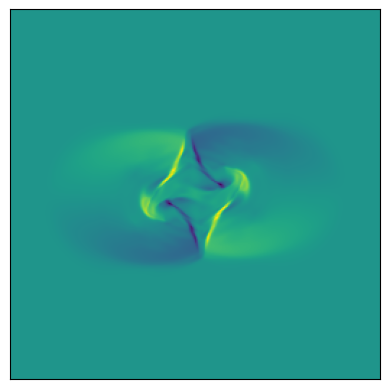

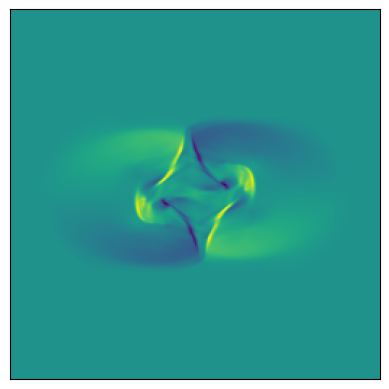

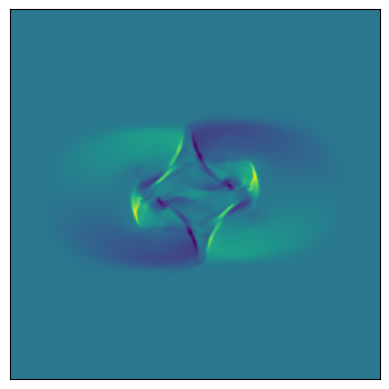

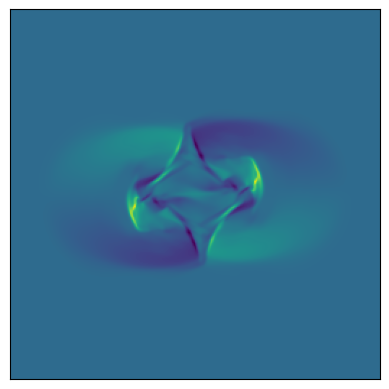

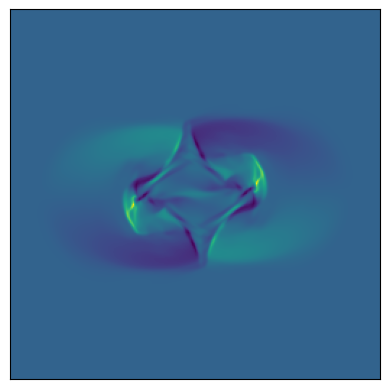

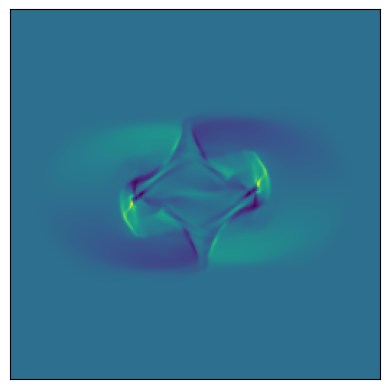

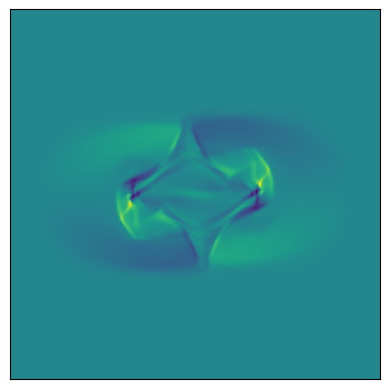

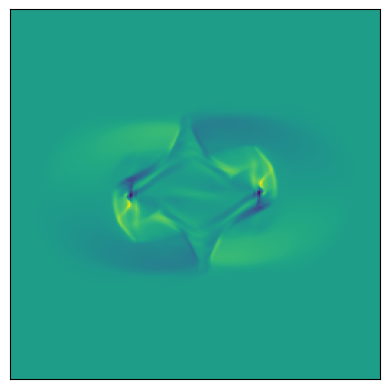

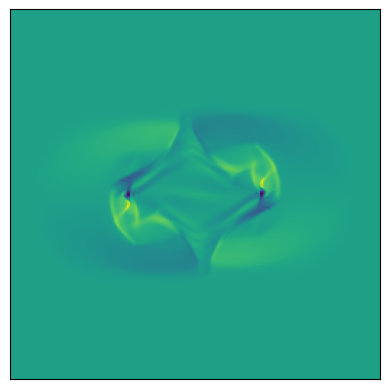

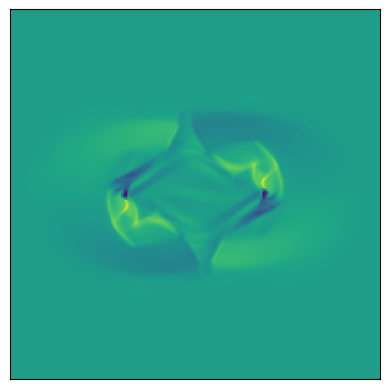

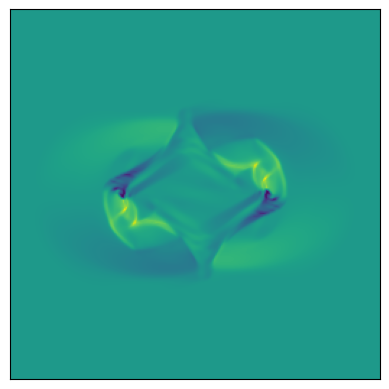

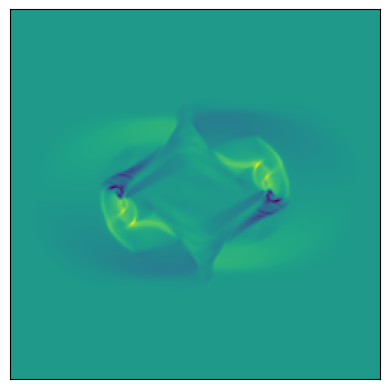

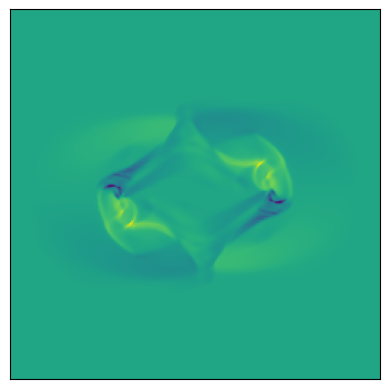

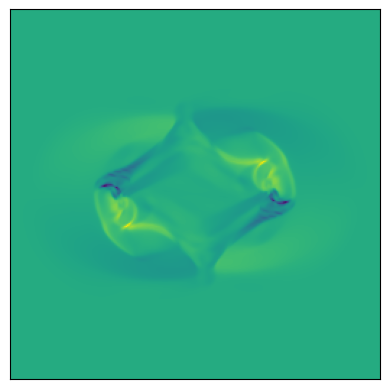

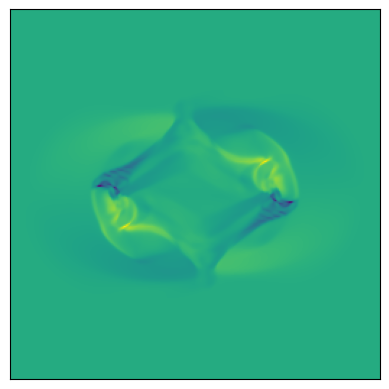

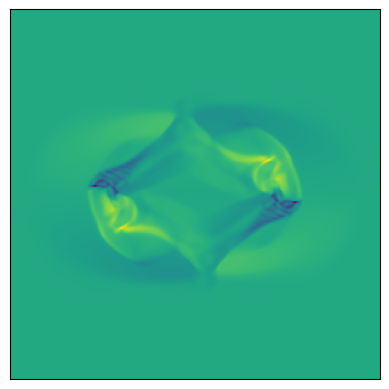

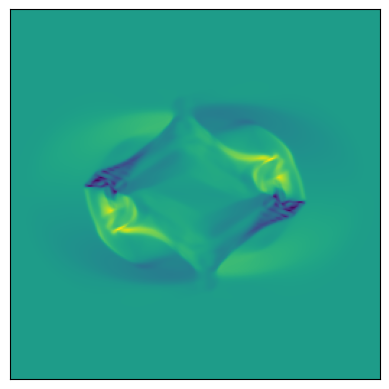

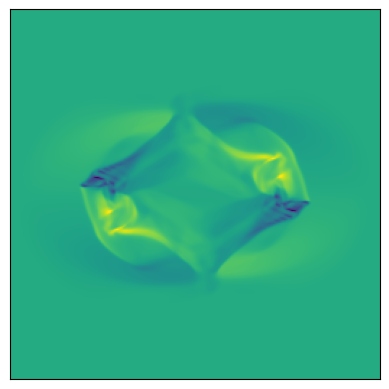

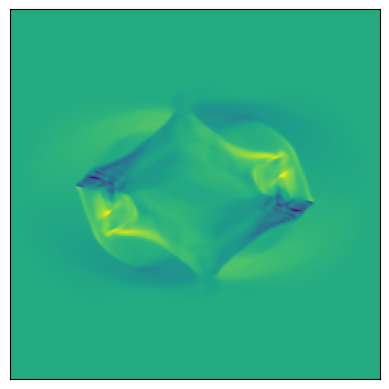

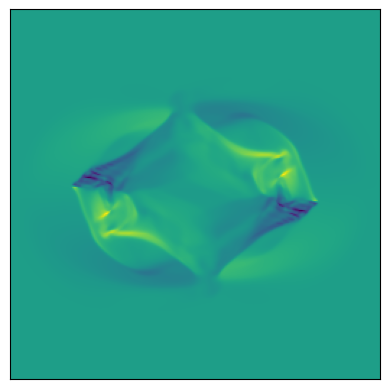

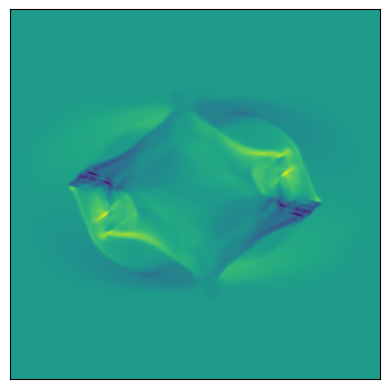

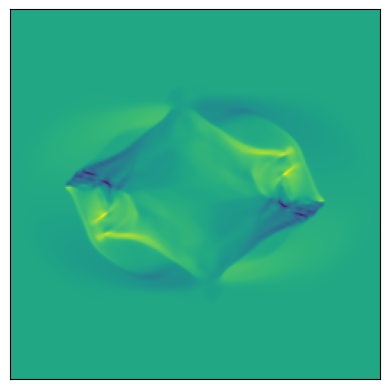

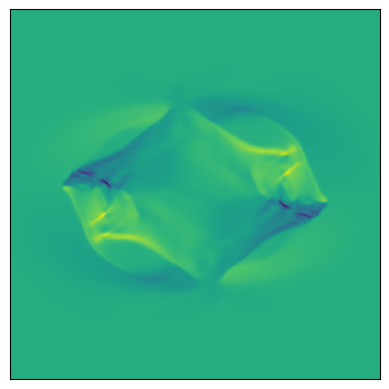

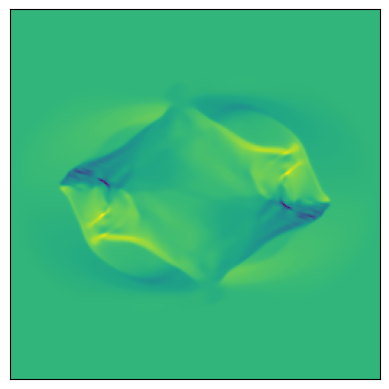

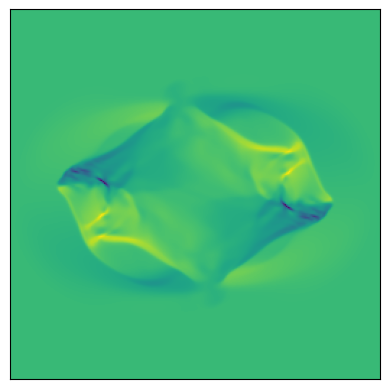

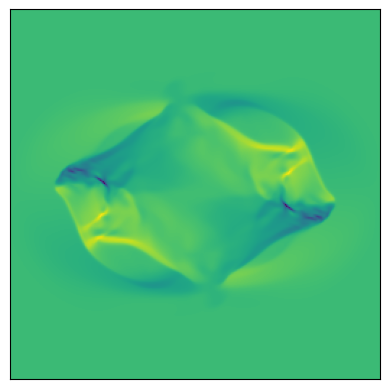

In [18]:
i=0
while i < len(sol):
    plt.cla()
    rho = sol[i][:N].T
    plt.imshow(rho)
    #plt.clim(0.8, 2.2)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i += 1
plt.show()

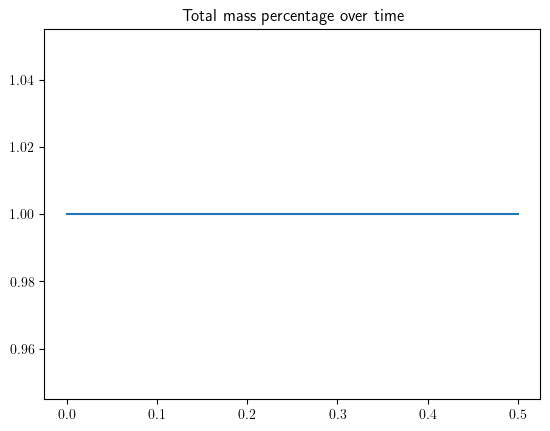

In [13]:
plt.plot(tOut*np.array(range(len(m))),m/m[0])
plt.title("Total mass percentage over time")
plt.show()

In [ ]:

t                      = 0    # s
tEnd                   = 0.5  # time at the end
tOut                   = 0.01 # time of each output
N                      = 2**8 # resolution
boxsize                = 10.  # in some unit system l
gamma                  = 5/3  # adiabatic index
zeta                   = 1    # bulk viscosity coefficient
eta                    = 10   # shear viscosity
tau_nu                 = 1    # relaxation time
theta                  = 1    # flux limiter variable (1<theta<2)
b                      = 0.1  # impact parameter

# Define Mesh
dx = boxsize / N   # box size
dy = dx
vol = dx**2        # volume of each box
#xlin = np.linspace(0.5*dx, (boxsize-0.5*dx), N)# simulation limits
xlin = np.linspace(-0.5*(boxsize-0.5*dx),0.5*(boxsize-0.5*dx), N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R1 = np.sqrt((X-2*np.ones(s))**2 + (Y-b*np.ones(s))**2)
R2 = np.sqrt((X+2*np.ones(s))**2 + (Y+b*np.ones(s))**2)

rho = ((1 - R2**2 )**4)*(R2 < 1) + ((1 - R1**2 )**4)*(R1 < 1) + 0.5*np.ones(s)
vx =  15*np.ones(s) * (R2 < 1) - 15*np.ones(s) * (R1 < 1)
vy =  np.zeros(s)
''' initial condition of Pi tensor '''
Pixx = np.zeros(s)
Pixy = np.zeros(s)
Piyx = np.zeros(s)
Piyy = np.zeros(s)

IC = np.vstack((rho,rho*vx,rho*vy,Pixx,Pixy,Piyx,Piyy)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example

sol, m = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, zeta, tau_nu, eta, theta))